# Understat

In [237]:
import pandas as pd #afin de manipuler les data frame
import numpy as np
from selenium import webdriver #pour naviguer sur internet de manière automatisée
from bs4 import BeautifulSoup #afin de parser notre code html
import re #afin d'utiliser des expressions régulières

#pour réaliser nos graphiques
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Présentation du site 

[Understat](https://understat.com/) est un site internet agrégeant les statistiques d’[Opta](https://www.optasportspro.com/) pour créer des tableaux basés sur les xG (Expected Goals) notamment.

Les expected goals (xG) correspondent au nombre de buts marqués par une équipe qui est attendu, sur la base de l’ensemble des tirs effectués.
 - Origine : ce concept a été introduit la première fois dans un papier par [Sam Green d'Opta](https://www.optasportspro.com/about/optapro-blog/posts/2012/blog-assessing-the-performance-of-premier-league-goalscorers/) en 2012 pour mesurer la performance des attaquants de Premier League. Cette métrique est par la suite devenue populaire dans le monde des analystes footballistiques et sa méthode de calcul a été dupliquée pour mesurer de nouvelles statistiques liées au football (les xA - Expected Assist - notamment).
 - Méthodologie : Chaque entreprise a son modèle propriétaire avec ses propres spécificités mais la plupart d'entre elles utilisent les concepts qui vont être explicités plus bas.
  - On divise le terrain en plusieurs zones afin de pouvoir diviser le nombre de buts marqués par tout le monde dans cette zone par le nombre de tirs pris dans cette zone afin d'obtenir un xG.
  - On place un xG spécifique pour certaines situations de jeu : penalties, corners et coup francs notamment.
  - On ajoute un coefficient spécifique selon le type de tir : un tir sur le pied faible ou une tête (selon la zone sur laquelle on se trouve sur le terrain) aura un xG plus faible par exemple.
  - On peut avoir des ajustements "propriétaires" à la discrétion de la société :
   - prendre en compte le nombre de défenseurs dans la zone lors d'un tir, le type de la passe clé (une passe au sol ou bien un centre aérien par exemple).
  - En additionnant les xG de chaque tir pris dans des zones différentes on obtient le nombre de buts attendus.
 
Le site web que nous allons scraper récupère les données brutes de positions de tir et les caractéristiques des joueurs depuis Opta (plus de 100 000 données de tirs avec 10 paramètres) afin d'entrainer un algorithme de prédiction basé sur des réseaux de neurones.

Nous avons décidé de scraper uniquement les données du championnat anglais lors de la saison 2017/2018 - individuelles et d'équipe - afin d'étudier la performance des joueurs et des équipes.

## 2. Web scraping

### 2.1. Fonctions

Cette fonction permet de récupérer le nom des colonnes sur la base d'une balise html.

In [238]:
def recup_header(soup, nomClass):
    
    liste_header = [] #on crée notre liste

    #on récupère le nom des colonnes sur la base de la balise html
    nomColonnes = soup.find('div', attrs = {'class': nomClass}).find('table').find_all('th')

    for header in nomColonnes:
        liste_header.append(header.get_text(strip = True)) #on récupère chaque élement pour le transformer en str
    
    return liste_header #on renvoie notre liste

Cette fonction permet de récupérer le corps du tableau sur la base d'une balise html.

In [239]:
def recup_corps(soup, nomClass):
    
    #on récupère le tableau sur la base de la balise html
    corpsTableau = soup.find('div', attrs = {'class': nomClass}).table.tbody 
    
    liste_lignes = [] #on crée notre liste
    
    for tr in corpsTableau.find_all('tr'): #pour chaque ligne dans le corps du tableau
        ligne = tr.find_all('td') #on récupère les données pour chaque colonne dans la ligne
        la_ligne = [] #on crée une ligne pour sauvegarder les résultats
        for element in ligne:
            la_ligne.append(element.get_text(strip = True)) #on ajoute le texte à la colonne qui correspond
        liste_lignes.append(la_ligne) #on rajoute la nouvelle ligne crée au tableau
    
    tableau = pd.DataFrame(liste_lignes, columns = recup_header(soup, nomClass))
    
    return tableau #on renvoie notre data frame

### 2.2. Récupération de la liste des équipes

Lors de notre première tentative pour scraper le site, nous ne sommes pas parvenus à récupérer les tableaux uniquement avec la fonction `BeautifulSoup` [module : `bs4`] car les données étaient encodées dans des variables Json.

Pour faire face à ce problème nous avons donc utilisé la classe `webdriber` [module : `Selenium`] et les fonctions associées à cette classe. Cela nous a permis d'accéder à un code plus lisible.

Contrairement à `requests` qui envoie une reqûete à un site internet et retourne une réponse contenant le code HTML de la page, `webdriver` permet ouvre un navigateur internet pouvant être contrôlé avec Python. Cela permet d'accéder aux informations de la même manière qu'un utilisateur classique et de faire croire au site internet que l'on ne cherche qu'à naviguer sur le site (puisque l'on utilise un navigateur web).

Il est donc nécessaire de télécharger la version adéquate selon votre OS de [ChromeDriver](https://sites.google.com/a/chromium.org/chromedriver/downloads) (cliquez sur le lien) et d'indiquer ci-dessous le chemin complet du fichier téléchargé.

NB : ne pas oublier l'extension **.exe** à la fin pour les OS Windows.

In [240]:
lienChromeDriver = "/Users/oumarndiaye/Downloads/chromedriver"

On peut à présent initialiser le navigateur web.

In [241]:
#définition des options que l'on souhaite pour notre navigateur
optionsChrome = webdriver.ChromeOptions() 
optionsChrome.add_argument("incognito") #navigation privée
optionsChrome.add_argument("headless") #permet d'exécuter le code sur une page distincte

navigateurWeb = webdriver.Chrome(lienChromeDriver, options = optionsChrome)

On récupère le code source de la page contenant le classement final du championnat.

In [242]:
navigateurWeb.get("https://understat.com/league/EPL/2017")

soup_team = BeautifulSoup(navigateurWeb.page_source, "lxml")
soup_team

<!DOCTYPE html>
<html class="wf-barlow-n5-active js flexbox flexboxlegacy canvas canvastext webgl no-touch geolocation postmessage websqldatabase indexeddb hashchange history draganddrop websockets rgba hsla multiplebgs backgroundsize borderimage borderradius boxshadow textshadow opacity cssanimations csscolumns cssgradients cssreflections csstransforms csstransforms3d csstransitions fontface generatedcontent video audio localstorage sessionstorage webworkers applicationcache svg inlinesvg smil svgclippaths wf-anton-n4-active wf-active" xmlns="http://www.w3.org/1999/xhtml"><head>
<base href="https://understat.com/"/>
<title>EPL xG Table and Scorers for the 2017/2018 season | Understat.com</title>
<meta charset="utf-8"/>
<meta content="xG table of EPL standings and top scorers for the 2017/2018 season, also tables from past seasons and other European football leagues." name="description"/>
<meta content="EPL, xg table,scorers, expected goals table, season 2017/2018" name="Keywords"/>
<l

On construit notre tableau contenant le classement final du championnat.

In [243]:
classementEPL = recup_corps(soup_team, "chemp jTable")
classementEPL.rename(columns = {'Team':'Equipe'}, inplace = True) #on change le nom d'une colonne
classementEPL.head(6)

,№,Equipe,M,W,D,L,G,GA,PTS,xG,xGA,xPTS
0,1,Manchester City,38,32,4,2,106,27,100,91.43-14.57,24.51-2.49,91.09-8.91
1,2,Manchester United,38,25,6,7,68,28,81,59.04-8.96,43.54+15.54,62.33-18.67
2,3,Tottenham,38,23,8,7,74,36,77,68.91-5.09,35.86-0.14,76.02-0.98
3,4,Liverpool,38,21,12,5,84,38,75,77.49-6.51,35.75-2.25,79.38+4.38
4,5,Chelsea,38,21,7,10,62,38,70,59.16-2.84,34.03-3.97,68.46-1.54
5,6,Arsenal,38,19,6,13,74,51,63,72.27-1.73,48.75-2.25,65.90+2.90


On récupère la liste des équipes ayant participé au championnat dans la table `classementEPL`

In [244]:
listeEquipes = classementEPL.loc[:,"Equipe"]
listeEquipes

0          Manchester City
1        Manchester United
2                Tottenham
3                Liverpool
4                  Chelsea
5                  Arsenal
6                  Burnley
7                  Everton
8                Leicester
9         Newcastle United
10          Crystal Palace
11             Bournemouth
12                West Ham
13                 Watford
14                Brighton
15            Huddersfield
16             Southampton
17                 Swansea
18                   Stoke
19    West Bromwich Albion
Name: Equipe, dtype: object

### 2.3. Récupération des données pour chaque équipe

On récupère plusieurs tables qui seront définies plus bas.

In [245]:
#création des tables
statsIndividuelles = pd.DataFrame()
situationButs = pd.DataFrame()
listeFormation = pd.DataFrame()
etatMatch = pd.DataFrame()
timingBut = pd.DataFrame()
zoneTirs = pd.DataFrame()
vitesseJeu = pd.DataFrame()
resultatsTirs = pd.DataFrame()

for equipe in listeEquipes:
    
    #on remplace le potentiel espace dans le nom d'une équipe un tiret du bas
    nomEquipe = equipe.replace(" ", "_")
    #on crée le l'adresse à partir de laquelle on accèdera aux données
    lien = "https://understat.com/team/" + nomEquipe + "/2017"
    
    navigateurWeb.get(lien) #on charge le lien sur Chrome
    soup_stats = BeautifulSoup(navigateurWeb.page_source, "lxml") #récupération du code html
    
    #récupération du tableau contenant les statisitiques individuelles
    statsIndividuellesEquipe = recup_corps(soup_stats, "players jTable")
    #récupération du tableau contenant les différentes situations de jeu lors de buts
    situationButsEquipe = recup_corps(soup_stats, "statistics jTable")
    
    #Par la suite, on clique sur un bouton présent sur la page afin de faire apparaître le tableau puis l'on récupère les données
    
    #Formation
    ##On cherche le bouton en question
    boutonListeFormation = navigateurWeb.find_elements_by_xpath("/html/body/div/div[3]/div[3]/div/div[1]/div/label[2]")[0]
    boutonListeFormation.click() #on clique dessus
    soup_stats = BeautifulSoup(navigateurWeb.page_source, "lxml")
    listeFormationEquipe = recup_corps(soup_stats, "statistics jTable")
    
    #Game state
    ##On cherche le bouton en question
    boutonEtatMatch = navigateurWeb.find_elements_by_xpath("/html/body/div/div[3]/div[3]/div/div[1]/div/label[3]")[0]
    boutonEtatMatch.click() #on clique dessus
    soup_stats = BeautifulSoup(navigateurWeb.page_source, "lxml")
    etatMatchEquipe = recup_corps(soup_stats, "statistics jTable")
    
    #Timing
    ##On cherche le bouton en question
    boutonTimingBut = navigateurWeb.find_elements_by_xpath("/html/body/div/div[3]/div[3]/div/div[1]/div/label[4]")[0]
    boutonTimingBut.click()
    soup_stats = BeautifulSoup(navigateurWeb.page_source, "lxml")
    timingButEquipe = recup_corps(soup_stats, "statistics jTable")
    
    #Shot Zones
    ##On cherche le bouton en question
    boutonZoneTirs = navigateurWeb.find_elements_by_xpath("/html/body/div/div[3]/div[3]/div/div[1]/div/label[5]")[0]
    boutonZoneTirs.click() #on clique dessus
    soup_stats = BeautifulSoup(navigateurWeb.page_source, "lxml")
    zoneTirsEquipe = recup_corps(soup_stats, "statistics jTable")    
    
    #Attack speed
    ##On cherche le bouton en question
    boutonVitesseJeu = navigateurWeb.find_elements_by_xpath("/html/body/div/div[3]/div[3]/div/div[1]/div/label[6]")[0]
    boutonVitesseJeu.click()
    soup_stats = BeautifulSoup(navigateurWeb.page_source, "lxml")
    vitesseJeuEquipe = recup_corps(soup_stats, "statistics jTable") 
    
    #Results
    ##On cherche le bouton en question
    boutonResultatsTire = navigateurWeb.find_elements_by_xpath("/html/body/div/div[3]/div[3]/div/div[1]/div/label[7]")[0]
    boutonResultatsTire.click() #on clique dessus
    soup_stats = BeautifulSoup(navigateurWeb.page_source, "lxml")
    resultatsTirsEquipe = recup_corps(soup_stats, "statistics jTable")
    
    #On rajoute une colonne contenant le nom de l'équipe
    statsIndividuellesEquipe["Equipe"] = equipe
    situationButsEquipe["Equipe"] = equipe
    listeFormationEquipe["Equipe"] = equipe
    etatMatchEquipe["Equipe"] = equipe
    timingButEquipe["Equipe"] = equipe
    zoneTirsEquipe["Equipe"] = equipe
    vitesseJeuEquipe["Equipe"] = equipe
    resultatsTirsEquipe["Equipe"] = equipe
    
    #on aggrège les résultats
    statsIndividuelles = statsIndividuelles.append(statsIndividuellesEquipe)
    situationButs = situationButs.append(situationButsEquipe)
    listeFormation = listeFormation.append(listeFormationEquipe)
    etatMatch = etatMatch.append(etatMatchEquipe)
    timingBut = timingBut.append(timingButEquipe)
    zoneTirs = zoneTirs.append(zoneTirsEquipe)
    vitesseJeu = vitesseJeu.append(vitesseJeuEquipe)
    resultatsTirs = resultatsTirs.append(resultatsTirsEquipe)
    
navigateurWeb.quit() #fermeture du navigateur web

## 3. Data engineering

### 3.1. Nettoyage

On crée une fonction pour nettoyer les colonnes.

In [246]:
def cleanColonnes(colonne):
    
    newColonne = [] #création de notre liste
    regex = r"([0-9.]+)" #on récupère uniquement les chiffres et les points
    
    for element in colonne:
        valeur = re.findall(regex, element)[0] #on récupère uniquement le nombre de gauche dans la colonne
        newColonne.append(valeur) #on aggrège nos résultats
        
    return newColonne

On nettoie et change le type des colonnes à présent

In [247]:
#Nettoyage des cellules
classementEPL["xG"] = cleanColonnes(classementEPL["xG"])
classementEPL["xGA"] = cleanColonnes(classementEPL["xGA"])
classementEPL["xPTS"] = cleanColonnes(classementEPL["xPTS"])

statsIndividuelles["xG"] = cleanColonnes(statsIndividuelles["xG"])
statsIndividuelles["xA"] = cleanColonnes(statsIndividuelles["xA"])

situationButs["xG"] = cleanColonnes(situationButs["xG"])
situationButs["xGA"] = cleanColonnes(situationButs["xGA"])

listeFormation["xG"] = cleanColonnes(listeFormation["xG"])
listeFormation["xGA"] = cleanColonnes(listeFormation["xGA"])

etatMatch["xG"] = cleanColonnes(etatMatch["xG"])
etatMatch["xGA"] = cleanColonnes(etatMatch["xGA"])

timingBut["xG"] = cleanColonnes(timingBut["xG"])
timingBut["xGA"] = cleanColonnes(timingBut["xGA"])

zoneTirs["xG"] = cleanColonnes(zoneTirs["xG"])
zoneTirs["xGA"] = cleanColonnes(zoneTirs["xGA"])

vitesseJeu["xG"] = cleanColonnes(vitesseJeu["xG"])
vitesseJeu["xGA"] = cleanColonnes(vitesseJeu["xGA"])

resultatsTirs["xG"] = cleanColonnes(resultatsTirs["xG"])
resultatsTirs["xGA"] = cleanColonnes(resultatsTirs["xGA"])


#on change le type des colonnes
classementEPL["№"] = pd.to_numeric(classementEPL["№"])
classementEPL["M"] = pd.to_numeric(classementEPL["M"], downcast = "float")
classementEPL["W"] = pd.to_numeric(classementEPL["W"], downcast = "float")
classementEPL["D"] = pd.to_numeric(classementEPL["D"], downcast = "float")
classementEPL["L"] = pd.to_numeric(classementEPL["L"], downcast = "float")
classementEPL["G"] = pd.to_numeric(classementEPL["G"], downcast = "float")
classementEPL["GA"] = pd.to_numeric(classementEPL["GA"], downcast = "float")
classementEPL["PTS"] = pd.to_numeric(classementEPL["PTS"], downcast = "float")
classementEPL["xG"] = pd.to_numeric(classementEPL["xG"], downcast = "float")
classementEPL["xGA"] = pd.to_numeric(classementEPL["xGA"], downcast = "float")
classementEPL["xPTS"] = pd.to_numeric(classementEPL["xPTS"], downcast = "float")

statsIndividuelles.drop(columns = ["№"], inplace = True)
statsIndividuelles["Pos"] = pd.Categorical(statsIndividuelles["Pos"], ordered = False)
statsIndividuelles["Apps"] = pd.to_numeric(statsIndividuelles["Apps"], downcast = "float")
statsIndividuelles["Min"] = pd.to_numeric(statsIndividuelles["Min"], downcast = "float")
statsIndividuelles["G"] = pd.to_numeric(statsIndividuelles["G"], downcast = "float")
statsIndividuelles["A"] = pd.to_numeric(statsIndividuelles["A"], downcast = "float")
statsIndividuelles["Sh90"] = pd.to_numeric(statsIndividuelles["Sh90"], downcast = "float")
statsIndividuelles["KP90"] = pd.to_numeric(statsIndividuelles["KP90"], downcast = "float")
statsIndividuelles["xG"] = pd.to_numeric(statsIndividuelles["xG"], downcast = "float")
statsIndividuelles["xA"] = pd.to_numeric(statsIndividuelles["xA"], downcast = "float")
statsIndividuelles["xG90"] = pd.to_numeric(statsIndividuelles["xG90"], downcast = "float")
statsIndividuelles["xA90"] = pd.to_numeric(statsIndividuelles["xA90"], downcast = "float")

situationButs.drop(columns = ["№"], inplace = True)
situationButs["Situation"] = pd.Categorical(situationButs["Situation"], ordered = False)
situationButs["Sh"] = pd.to_numeric(situationButs["Sh"], downcast = "float")
situationButs["G"] = pd.to_numeric(situationButs["G"], downcast = "float")
situationButs["ShA"] = pd.to_numeric(situationButs["ShA"], downcast = "float")
situationButs["GA"] = pd.to_numeric(situationButs["GA"], downcast = "float")
situationButs["xG"] = pd.to_numeric(situationButs["xG"], downcast = "float")
situationButs["xGA"] = pd.to_numeric(situationButs["xGA"], downcast = "float")
situationButs["xGD"] = pd.to_numeric(situationButs["xGD"], downcast = "float")
situationButs["xG/Sh"] = pd.to_numeric(situationButs["xG/Sh"], downcast = "float")
situationButs["xGA/Sh"] = pd.to_numeric(situationButs["xGA/Sh"], downcast = "float")

listeFormation.drop(columns = ["№"], inplace = True)
listeFormation["Formation"] = pd.Categorical(listeFormation["Formation"], ordered = False)
listeFormation["Min"] = pd.to_numeric(listeFormation["Min"], downcast = "float")
listeFormation["Sh"] = pd.to_numeric(listeFormation["Sh"], downcast = "float")
listeFormation["G"] = pd.to_numeric(listeFormation["G"], downcast = "float")
listeFormation["ShA"] = pd.to_numeric(listeFormation["ShA"], downcast = "float")
listeFormation["GA"] = pd.to_numeric(listeFormation["GA"], downcast = "float")
listeFormation["xG"] = pd.to_numeric(listeFormation["xG"], downcast = "float")
listeFormation["xGA"] = pd.to_numeric(listeFormation["xGA"], downcast = "float")
listeFormation["xGD"] = pd.to_numeric(listeFormation["xGD"], downcast = "float")
listeFormation["xG90"] = pd.to_numeric(listeFormation["xG90"], downcast = "float")
listeFormation["xGA90"] = pd.to_numeric(listeFormation["xGA90"], downcast = "float")

etatMatch.drop(columns = ["№"], inplace = True)
etatMatch["Game state"] = pd.Categorical(etatMatch["Game state"], ordered = False)
etatMatch["Min"] = pd.to_numeric(etatMatch["Min"], downcast = "float")
etatMatch["Sh"] = pd.to_numeric(etatMatch["Sh"], downcast = "float")
etatMatch["G"] = pd.to_numeric(etatMatch["G"], downcast = "float")
etatMatch["ShA"] = pd.to_numeric(etatMatch["ShA"], downcast = "float")
etatMatch["GA"] = pd.to_numeric(etatMatch["GA"], downcast = "float")
etatMatch["xG"] = pd.to_numeric(etatMatch["xG"], downcast = "float")
etatMatch["xGA"] = pd.to_numeric(etatMatch["xGA"], downcast = "float")
etatMatch["xGD"] = pd.to_numeric(etatMatch["xGD"], downcast = "float")
etatMatch["xG90"] = pd.to_numeric(etatMatch["xG90"], downcast = "float")
etatMatch["xGA90"] = pd.to_numeric(etatMatch["xGA90"], downcast = "float")

timingBut["№"].drop(columns = ["№"], inplace = True)
timingBut["Timing"] = pd.Categorical(timingBut["Timing"], ordered = False)
timingBut["Sh"] = pd.to_numeric(timingBut["Sh"], downcast = "float")
timingBut["G"] = pd.to_numeric(timingBut["G"], downcast = "float")
timingBut["ShA"] = pd.to_numeric(timingBut["ShA"], downcast = "float")
timingBut["GA"] = pd.to_numeric(timingBut["GA"], downcast = "float")
timingBut["xG"] = pd.to_numeric(timingBut["xG"], downcast = "float")
timingBut["xGA"] = pd.to_numeric(timingBut["xGA"], downcast = "float")
timingBut["xGD"] = pd.to_numeric(timingBut["xGD"], downcast = "float")
timingBut["xG/Sh"] = pd.to_numeric(timingBut["xG/Sh"], downcast = "float")
timingBut["xGA/Sh"] = pd.to_numeric(timingBut["xGA/Sh"], downcast = "float")

zoneTirs["№"].drop(columns = ["№"], inplace = True)
zoneTirs["Shot zones"] = pd.Categorical(zoneTirs["Shot zones"], ordered = False)
zoneTirs["Sh"] = pd.to_numeric(zoneTirs["Sh"], downcast = "float")
zoneTirs["G"] = pd.to_numeric(zoneTirs["G"], downcast = "float")
zoneTirs["ShA"] = pd.to_numeric(zoneTirs["ShA"], downcast = "float")
zoneTirs["GA"] = pd.to_numeric(zoneTirs["GA"], downcast = "float")
zoneTirs["xG"] = pd.to_numeric(zoneTirs["xG"], downcast = "float")
zoneTirs["xGA"] = pd.to_numeric(zoneTirs["xGA"], downcast = "float")
zoneTirs["xGD"] = pd.to_numeric(zoneTirs["xGD"], downcast = "float")
zoneTirs["xG/Sh"] = pd.to_numeric(zoneTirs["xG/Sh"], downcast = "float")
zoneTirs["xGA/Sh"] = pd.to_numeric(zoneTirs["xGA/Sh"], downcast = "float")

vitesseJeu["№"].drop(columns = ["№"], inplace = True)
vitesseJeu["Attack speed"] = pd.Categorical(vitesseJeu["Attack speed"], ordered = False)
vitesseJeu["Sh"] = pd.to_numeric(vitesseJeu["Sh"], downcast = "float")
vitesseJeu["G"] = pd.to_numeric(vitesseJeu["G"], downcast = "float")
vitesseJeu["ShA"] = pd.to_numeric(vitesseJeu["ShA"], downcast = "float")
vitesseJeu["GA"] = pd.to_numeric(vitesseJeu["GA"], downcast = "float")
vitesseJeu["xG"] = pd.to_numeric(vitesseJeu["xG"], downcast = "float")
vitesseJeu["xGA"] = pd.to_numeric(vitesseJeu["xGA"], downcast = "float")
vitesseJeu["xGD"] = pd.to_numeric(vitesseJeu["xGD"], downcast = "float")
vitesseJeu["xG/Sh"] = pd.to_numeric(vitesseJeu["xG/Sh"], downcast = "float")
vitesseJeu["xGA/Sh"] = pd.to_numeric(vitesseJeu["xGA/Sh"], downcast = "float")

resultatsTirs["№"].drop(columns = ["№"], inplace = True)
resultatsTirs["Result"] = pd.Categorical(resultatsTirs["Result"], ordered = False)
resultatsTirs["Sh"] = pd.to_numeric(resultatsTirs["Sh"], downcast = "float")
resultatsTirs["G"] = pd.to_numeric(resultatsTirs["G"], downcast = "float")
resultatsTirs["ShA"] = pd.to_numeric(resultatsTirs["ShA"], downcast = "float")
resultatsTirs["GA"] = pd.to_numeric(resultatsTirs["GA"], downcast = "float")
resultatsTirs["xG"] = pd.to_numeric(resultatsTirs["xG"], downcast = "float")
resultatsTirs["xGA"] = pd.to_numeric(resultatsTirs["xGA"], downcast = "float")
resultatsTirs["xGD"] = pd.to_numeric(resultatsTirs["xGD"], downcast = "float")
resultatsTirs["xG/Sh"] = pd.to_numeric(resultatsTirs["xG/Sh"], downcast = "float")
resultatsTirs["xGA/Sh"] = pd.to_numeric(resultatsTirs["xGA/Sh"], downcast = "float")

Ensemble des tables :

In [248]:
statsIndividuelles.head()

,Player,Pos,Apps,Min,G,A,Sh90,KP90,xG,xA,xG90,xA90,Equipe
0,Sergio Agüero,F,25.0,1985.0,21.0,6.0,4.31,1.77,18.57,6.53,0.84,0.30,Manchester City
1,Raheem Sterling,F,33.0,2594.0,18.0,11.0,3.02,1.91,18.83,8.84,0.65,0.31,Manchester City
2,Gabriel Jesus,F,29.0,1692.0,13.0,3.0,2.93,0.96,15.37,2.31,0.82,0.12,Manchester City
3,Leroy Sané,F M,32.0,2421.0,10.0,15.0,2.08,2.16,6.24,9.05,0.23,0.34,Manchester City
4,David Silva,M,29.0,2442.0,9.0,11.0,1.99,2.25,9.24,8.83,0.34,0.33,Manchester City


In [249]:
situationButs.head()

,Situation,Sh,G,ShA,GA,xG,xGA,xGD,xG/Sh,xGA/Sh,Equipe
0,Open play,509.0,82.0,159.0,22.0,73.120003,17.309999,55.810001,0.14,0.11,Manchester City
1,From corner,95.0,10.0,36.0,1.0,8.950000,3.130000,5.820000,0.09,0.09,Manchester City
2,Direct Freekick,30.0,1.0,10.0,1.0,1.870000,0.600000,1.260000,0.06,0.06,Manchester City
3,Set piece,21.0,4.0,27.0,1.0,3.120000,2.340000,0.780000,0.15,0.09,Manchester City
4,Penalty,8.0,6.0,2.0,0.0,6.090000,1.520000,4.570000,0.76,0.76,Manchester City


In [250]:
listeFormation.head()

,Formation,Min,Sh,G,ShA,GA,xG,xGA,xGD,xG90,xGA90,Equipe
0,4-3-3,2881.0,534.0,83.0,192.0,21.0,75.230003,20.48,54.75,2.35,0.64,Manchester City
1,3-1-4-2,218.0,37.0,4.0,18.0,1.0,5.260000,1.54,3.72,2.17,0.63,Manchester City
2,4-1-2-1-2,129.0,25.0,4.0,8.0,2.0,3.970000,1.14,2.83,2.77,0.79,Manchester City
3,3-5-2,93.0,18.0,3.0,6.0,1.0,1.920000,0.86,1.06,1.85,0.83,Manchester City
4,4-2-4-0,88.0,16.0,2.0,3.0,0.0,1.590000,0.16,1.44,1.63,0.16,Manchester City


In [251]:
etatMatch.head()

,Game state,Min,Sh,G,ShA,GA,xG,xGA,xGD,xG90,xGA90,Equipe
0,Goal diff 0,1662.0,294.0,39.0,85.0,6.0,32.520000,8.64,23.879999,1.76,0.47,Manchester City
1,Goal diff > +1,908.0,179.0,31.0,71.0,10.0,30.559999,7.83,22.730000,3.03,0.78,Manchester City
2,Goal diff +1,826.0,153.0,26.0,64.0,7.0,25.379999,7.68,17.700001,2.77,0.84,Manchester City
3,Goal diff -1,143.0,33.0,5.0,12.0,1.0,4.190000,0.73,3.460000,2.64,0.46,Manchester City
4,Goal diff < -1,24.0,4.0,2.0,2.0,1.0,0.510000,0.04,0.480000,1.92,0.14,Manchester City


In [252]:
timingBut.head()

,№,Timing,Sh,G,ShA,GA,xG,xGA,xGD,xG/Sh,xGA/Sh,Equipe
0,1,1-15,98.0,13.0,41.0,3.0,10.420000,3.98,6.44,0.11,0.10,Manchester City
1,2,16-30,120.0,19.0,28.0,2.0,15.040000,2.76,12.28,0.13,0.10,Manchester City
2,3,31-45,101.0,11.0,44.0,5.0,14.250000,3.75,10.50,0.14,0.09,Manchester City
3,4,46-60,126.0,19.0,38.0,4.0,19.129999,4.51,14.62,0.15,0.12,Manchester City
4,5,61-75,103.0,16.0,28.0,7.0,17.520000,2.81,14.71,0.17,0.10,Manchester City


In [253]:
zoneTirs.head()

,№,Shot zones,Sh,G,ShA,GA,xG,xGA,xGD,xG/Sh,xGA/Sh,Equipe
0,1,Out of box,252.0,13.0,96.0,6.0,8.650000,2.930000,5.720000,0.03,0.03,Manchester City
1,2,Penalty area,355.0,64.0,118.0,16.0,58.750000,15.650000,43.099998,0.17,0.13,Manchester City
2,3,Six-yard box,56.0,26.0,20.0,3.0,25.750000,6.330000,19.420000,0.46,0.32,Manchester City
0,1,Out of box,213.0,12.0,172.0,3.0,6.910000,4.860000,2.050000,0.03,0.03,Manchester United
1,2,Penalty area,254.0,43.0,229.0,14.0,36.900002,28.389999,8.520000,0.15,0.12,Manchester United


In [254]:
vitesseJeu.head()

,№,Attack speed,Sh,G,ShA,GA,xG,xGA,xGD,xG/Sh,xGA/Sh,Equipe
0,1,Normal,414.0,62.0,134.0,21.0,58.689999,15.760000,42.919998,0.14,0.12,Manchester City
1,2,Standard,154.0,21.0,75.0,3.0,20.030001,7.600000,12.430000,0.13,0.10,Manchester City
2,3,Slow,62.0,10.0,12.0,1.0,6.070000,0.690000,5.380000,0.10,0.06,Manchester City
3,4,Fast,33.0,10.0,13.0,0.0,8.360000,0.860000,7.500000,0.25,0.07,Manchester City
0,1,Normal,335.0,40.0,305.0,13.0,37.750000,27.530001,10.220000,0.11,0.09,Manchester United


In [255]:
resultatsTirs.head()

,№,Result,Sh,G,ShA,GA,xG,xGA,xGD,xG/Sh,xGA/Sh,Equipe
0,1,Goal,103.0,103.0,25.0,25.0,37.919998,6.28,31.65,0.37,0.25,Manchester City
1,2,Blocked shot,155.0,0.0,53.0,0.0,10.430000,2.84,7.60,0.07,0.05,Manchester City
2,3,Saved shot,158.0,0.0,60.0,0.0,19.889999,6.18,13.71,0.13,0.10,Manchester City
3,4,Missed shot,234.0,0.0,92.0,0.0,21.450001,8.94,12.50,0.09,0.10,Manchester City
4,5,Shot on post,13.0,0.0,4.0,0.0,3.460000,0.67,2.78,0.27,0.17,Manchester City


### 3.2. Création de variables 

Nous allons créer les varibles suivantes :
 - **G-xG** (Nombre de buts marqués - xG) : pour mesurer la capacité d'un joueur ou d'une équipe à convertir ses occasions de but
 - **A-xA** (Nombre de passes décisives - xA) : pour mesurer la capacité d'un joueur ou d'une équipe à mettre un joueur en position de marquer
 - **G90** (Nombre de buts marqués / (Minutes jouées / 90)) : pour voir le nombre de buts marqués toutes les 90 minutes.
 - **G90-xG90** (Nombre de buts marqués par 90 minutes - xG par 90 minutes) : pour mesurer la capacité d'un joueur ou d'une équipe à convertir ses occasions de but toutes les 90 minutes
 - **xG90/Sh90** (xG90 / Nombre de tirs par 90 minutes) : pour mesurer la qualité de la sélection de tirs d'un joueur
 - **xA90/KP90** (xA90 / Nombre de passes clés par 90 minutes) : pour mesurer la capacité d'un joueur à mettre son coéquipier en position de marquer
 - **Diff** (Nombre de buts marqués - nombre de buts encaissés) : la différence de buts


In [256]:
#la différence entre le nombre de buts et le "nombre de buts attendus"
statsIndividuelles.insert(11,"G-xG", statsIndividuelles.G - statsIndividuelles.xG)
#la différence entre le nombre de passes décisives et le nombre de "passes décisives attendues"
statsIndividuelles.insert(13,"A-xA", statsIndividuelles.A - statsIndividuelles.xA)
#nombre de buts par 90 min
statsIndividuelles.insert(7,"G90", statsIndividuelles.G / (statsIndividuelles.Min / 90))
#la différence entre le nombre de buts par 90 minutes et le "nombre de buts attendus par 90 minutes"
statsIndividuelles.insert(13,"G90-xG90", statsIndividuelles.G90 - statsIndividuelles.xG90)
#le ratio entre le "nombre de buts attendus par 90 minutes" et le nombre de tirs pris par 90 minutes
statsIndividuelles.insert(14,"xG90/Sh90", statsIndividuelles.xG90 / statsIndividuelles.Sh90)
#le ratio entre le nombre de "passes décisives attendues" et le nombre de passes clés par 90 minutes
statsIndividuelles.insert(15,"xA90/KP90", statsIndividuelles.xA90 / statsIndividuelles.KP90)

#les joueurs ayant le plus surperformé en termes de buts marqués
statsIndividuelles.sort_values(by = "G-xG", ascending = False).head()

,Player,Pos,Apps,Min,G,A,Sh90,G90,KP90,xG,xA,xG90,G-xG,G90-xG90,xG90/Sh90,xA90/KP90,xA90,A-xA,Equipe
0,Mohamed Salah,F M,36.0,2954.0,32.0,10.0,4.36,0.974949,1.89,25.139999,8.34,0.77,6.860001,0.204949,0.176605,0.132275,0.25,1.66,Liverpool
1,Riyad Mahrez,F M,36.0,2977.0,12.0,10.0,2.24,0.362781,1.72,6.610000,7.55,0.20,5.390000,0.162781,0.089286,0.133721,0.23,2.45,Leicester
0,Jamie Vardy,F,37.0,3269.0,20.0,1.0,1.93,0.550627,0.91,15.270000,3.63,0.42,4.730000,0.130627,0.217617,0.109890,0.10,-2.63,Leicester
1,Roberto Firmino,F M,37.0,2814.0,15.0,7.0,2.69,0.479744,1.79,10.760000,7.68,0.34,4.240000,0.139744,0.126394,0.139665,0.25,-0.68,Liverpool
0,Abdoulaye Doucouré,M,37.0,3326.0,7.0,3.0,1.24,0.189417,1.08,3.110000,2.39,0.08,3.890000,0.109417,0.064516,0.055556,0.06,0.61,Watford


In [257]:
#la différence entre le nombre de buts et le "nombre de buts attendus"
situationButs.insert(8,"G-xG", situationButs.G - situationButs.xG)
#la différence entre le nombre de buts encaissés et le "nombre de buts encaissés attendus"
situationButs.insert(9,"GA-xGA", situationButs.GA - situationButs.xGA)
#la différence entre le nombre de buts marqués et le nombre de buts encaissés
situationButs.insert(5,"Diff", situationButs.G - situationButs.GA)

#les équipes ayant le plus surperformé en termes de buts marqués
situationButs.sort_values(by = "GA-xGA", ascending = False).head()

,Situation,Sh,G,ShA,GA,Diff,xG,xGA,xGD,G-xG,GA-xGA,xG/Sh,xGA/Sh,Equipe
0,Open play,263.0,19.0,314.0,44.0,-25.0,23.010000,36.230000,-13.210000,-4.010000,7.770000,0.09,0.12,Huddersfield
0,Open play,329.0,21.0,365.0,43.0,-22.0,26.910000,35.540001,-8.630000,-5.910000,7.459999,0.08,0.10,Southampton
0,Open play,258.0,31.0,397.0,47.0,-16.0,30.059999,40.160000,-10.100000,0.940001,6.840000,0.12,0.10,Everton
1,From corner,83.0,8.0,73.0,11.0,-3.0,9.760000,5.710000,4.040000,-1.760000,5.290000,0.12,0.08,Leicester
0,Open play,509.0,82.0,159.0,22.0,60.0,73.120003,17.309999,55.810001,8.879997,4.690001,0.14,0.11,Manchester City


In [258]:
#la différence entre le nombre de buts et le "nombre de buts attendus"
etatMatch.insert(8,"G-xG", etatMatch.G - etatMatch.xG)
#la différence entre le nombre de buts encaissés et le "nombre de buts encaissés attendus"
etatMatch.insert(9,"GA-xGA", etatMatch.GA - etatMatch.xGA)
#la différence entre le nombre de buts marqués et le nombre de buts encaissés
etatMatch.insert(5,"Diff", etatMatch.G - etatMatch.GA)

#les équipes ayant passé le plus de temps avec 1 but à rattraper
etatMatch[etatMatch["Game state"] == "Goal diff -1"].sort_values(by = "Min", ascending = False).head()

,Game state,Min,Sh,G,ShA,Diff,GA,xG,xGA,G-xG,GA-xGA,xGD,xG90,xGA90,Equipe
1,Goal diff -1,1008.0,149.0,17.0,132.0,8.0,9.0,13.35,14.29,3.65,-5.29,-0.94,1.19,1.28,Bournemouth
1,Goal diff -1,937.0,120.0,7.0,109.0,-3.0,10.0,9.41,15.85,-2.41,-5.85,-6.44,0.90,1.52,Swansea
1,Goal diff -1,740.0,105.0,5.0,92.0,-3.0,8.0,6.31,11.18,-1.31,-3.18,-4.88,0.77,1.36,Newcastle United
1,Goal diff -1,718.0,103.0,8.0,122.0,5.0,3.0,9.17,13.46,-1.17,-10.46,-4.29,1.15,1.69,Burnley
1,Goal diff -1,682.0,88.0,6.0,76.0,-6.0,12.0,10.76,12.61,-4.76,-0.61,-1.85,1.42,1.66,Watford


In [259]:
#la différence entre le nombre de buts et le "nombre de buts attendus"
timingBut.insert(9,"G-xG", timingBut.G - timingBut.xG)

#la différence entre le nombre de buts encaissés et le "nombre de buts encaissés attendus"
timingBut.insert(10,"GA-xGA", timingBut.GA - timingBut.xGA)

#les équipes marquant le plus dans le 1/4 d'heure après la pause
timingBut[timingBut["Timing"] == "46-60"].sort_values(by = "G", ascending = False).head()

,№,Timing,Sh,G,ShA,GA,xG,xGA,xGD,G-xG,GA-xGA,xG/Sh,xGA/Sh,Equipe
3,4,46-60,113.0,20.0,47.0,3.0,15.140000,4.63,10.51,4.860000,-1.63,0.13,0.10,Tottenham
3,4,46-60,126.0,19.0,38.0,4.0,19.129999,4.51,14.62,-0.129999,-0.51,0.15,0.12,Manchester City
3,4,46-60,126.0,18.0,56.0,11.0,15.700000,9.69,6.01,2.300000,1.31,0.12,0.17,Liverpool
3,4,46-60,97.0,17.0,84.0,8.0,15.200000,7.72,7.48,1.800000,0.28,0.16,0.09,Arsenal
3,4,46-60,93.0,13.0,75.0,6.0,13.030000,9.94,3.10,-0.030000,-3.94,0.14,0.13,Manchester United


In [260]:
#la différence entre le nombre de buts et le "nombre de buts attendus"
zoneTirs.insert(9,"G-xG", zoneTirs.G - zoneTirs.xG)

#la différence entre le nombre de buts encaissés et le "nombre de buts encaissés attendus"
zoneTirs.insert(10,"GA-xGA", zoneTirs.GA - zoneTirs.xGA)

#les équipes sur-performant le plus en termes de buts sur des tirs en dehors de la surface
zoneTirs[zoneTirs["Shot zones"] == "Out of box"].sort_values(by = "G-xG", ascending = False).head()

,№,Shot zones,Sh,G,ShA,GA,xG,xGA,xGD,G-xG,GA-xGA,xG/Sh,xGA/Sh,Equipe
0,1,Out of box,213.0,12.0,172.0,3.0,6.91,4.86,2.05,5.09,-1.86,0.03,0.03,Manchester United
0,1,Out of box,138.0,9.0,240.0,10.0,3.99,7.58,-3.60,5.01,2.42,0.03,0.03,West Ham
0,1,Out of box,252.0,13.0,96.0,6.0,8.65,2.93,5.72,4.35,3.07,0.03,0.03,Manchester City
0,1,Out of box,128.0,8.0,241.0,10.0,3.68,7.01,-3.33,4.32,2.99,0.03,0.03,Everton
0,1,Out of box,154.0,8.0,217.0,8.0,5.05,7.08,-2.03,2.95,0.92,0.03,0.03,Stoke


In [261]:
#la différence entre le nombre de buts et le "nombre de buts attendus"
vitesseJeu.insert(9,"G-xG", vitesseJeu.G - vitesseJeu.xG)

#la différence entre le nombre de buts encaissés et le "nombre de buts encaissés attendus"
vitesseJeu.insert(10,"GA-xGA", vitesseJeu.GA - vitesseJeu.xGA)

#les équipes tirant le plus en jouant sur un tempo faible
vitesseJeu[vitesseJeu["Attack speed"] == "Slow"].sort_values(by = "Sh", ascending = False).head()

,№,Attack speed,Sh,G,ShA,GA,xG,xGA,xGD,G-xG,GA-xGA,xG/Sh,xGA/Sh,Equipe
2,3,Slow,62.0,10.0,12.0,1.0,6.07,0.69,5.38,3.93,0.31,0.10,0.06,Manchester City
2,3,Slow,39.0,4.0,16.0,0.0,2.88,1.26,1.62,1.12,-1.26,0.07,0.08,Manchester United
3,4,Slow,33.0,6.0,12.0,2.0,2.75,0.96,1.78,3.25,1.04,0.08,0.08,Liverpool
3,4,Slow,32.0,2.0,15.0,1.0,2.75,0.89,1.86,-0.75,0.11,0.09,0.06,Tottenham
2,3,Slow,30.0,1.0,25.0,1.0,1.26,2.24,-0.98,-0.26,-1.24,0.04,0.09,Southampton


## 4. Analyse des données

### 4.1. Description des statistiques avancées

#### 4.1.1. Définition des variables 

Les postes :
 - GK : gardien de but
 - D : défenseur
 - D M : milieu défensif
 - M : milieu
 - F M : milieu offsenif
 - F : attaquant

In [262]:
statsIndividuelles["Pos"].unique()

[F, F M, M, D, D M, GK, S, D F M]
Categories (8, object): [F, F M, M, D, D M, GK, S, D F M]

Les postes suivants sont aussi présents :
 - S : semble regrouper les joueurs ayant joué moins de 300 minutes sur la saison
 - D F M : ne concerne que 4 joueurs

In [263]:
statsIndividuelles[statsIndividuelles["Pos"] == "S"].loc[:, ["Apps", "Min"]].describe()

,Apps,Min
count,41.000000,41.000000
mean,2.707317,26.463415
std,2.561678,42.449440
min,1.000000,1.000000
25%,1.000000,7.000000
50%,2.000000,15.000000
75%,3.000000,30.000000
max,14.000000,264.000000


In [264]:
statsIndividuelles[statsIndividuelles["Pos"] == "D F M"]["Player"].count()

4

Les 5 actions de jeu considérées :

In [265]:
situationButs["Situation"].unique()

[Open play, From corner, Direct Freekick, Set piece, Penalty]
Categories (5, object): [Open play, From corner, Direct Freekick, Set piece, Penalty]

Les 3 zones de tir considérées :

In [266]:
zoneTirs["Shot zones"].unique()

[Out of box, Penalty area, Six-yard box]
Categories (3, object): [Out of box, Penalty area, Six-yard box]

Les 5 situations possibles suite à un tir :

In [267]:
resultatsTirs["Result"].unique()

[Goal, Blocked shot, Saved shot, Missed shot, Shot on post]
Categories (5, object): [Goal, Blocked shot, Saved shot, Missed shot, Shot on post]

Les 20 tactiques utilisées lors de la saison :

In [268]:
listeFormation["Formation"].unique()

[4-3-3, 3-1-4-2, 4-1-2-1-2, 3-5-2, 4-2-4-0, ..., 4-3-2-1, 4-2-2-2, 4-4-1-1, 3-4-3, 4-3-1-2]
Length: 20
Categories (20, object): [4-3-3, 3-1-4-2, 4-1-2-1-2, 3-5-2, ..., 4-2-2-2, 4-4-1-1, 3-4-3, 4-3-1-2]

Les 5 scénario de match considérés :

In [269]:
etatMatch["Game state"].unique()

[Goal diff 0, Goal diff > +1, Goal diff +1, Goal diff -1, Goal diff < -1]
Categories (5, object): [Goal diff 0, Goal diff > +1, Goal diff +1, Goal diff -1, Goal diff < -1]

Les 6 périodes considéres durant un match (on le match par quart d'heure) :

In [270]:
timingBut["Timing"].unique()

[1-15, 16-30, 31-45, 46-60, 61-75, 76+]
Categories (6, object): [1-15, 16-30, 31-45, 46-60, 61-75, 76+]

Les 4 tempo de jeu considérés :

In [271]:
vitesseJeu["Attack speed"].unique()

[Normal, Standard, Slow, Fast]
Categories (4, object): [Normal, Standard, Slow, Fast]

### 4.2. Description des données

***9 tableaux***

**classementEPL** : le classement final de la saison 2017-2018

In [272]:
classementEPL.head(6)

,№,Equipe,M,W,D,L,G,GA,PTS,xG,xGA,xPTS
0,1,Manchester City,38.0,32.0,4.0,2.0,106.0,27.0,100.0,91.430000,24.510000,91.089996
1,2,Manchester United,38.0,25.0,6.0,7.0,68.0,28.0,81.0,59.040001,43.540001,62.330002
2,3,Tottenham,38.0,23.0,8.0,7.0,74.0,36.0,77.0,68.910004,35.860001,76.019997
3,4,Liverpool,38.0,21.0,12.0,5.0,84.0,38.0,75.0,77.489998,35.750000,79.379997
4,5,Chelsea,38.0,21.0,7.0,10.0,62.0,38.0,70.0,59.160000,34.029999,68.459999
5,6,Arsenal,38.0,19.0,6.0,13.0,74.0,51.0,63.0,72.269997,48.750000,65.900002


Liste des variables présentes dans le tableau ci-dessus :
 - La variable `№` : correspond au classement final de l'équipe
 - La variable `Equipe` : correspond au nom de l'équipe
 - La variable `M`(Matches) : représente le nombre de match disputés par chacune des équipes du championnat
 - La variable `W`(Wins) : représente le nombre total de matchs gagnés par une équipe tout au long de la saison
 - La variable `D`(Draws) : représente le nombre total de matchs nuls d’une équipe tout au long de la saison 
 - La variable `L`(Loses) : représente le nombre total de matchs perdus d’une équipe tout au long de la saison 
 - La variable `G`(Goals for) : représente le nombre total de buts marqués par une équipe tout au long de la saison
 - La variable `GA`(Goals against) : représente le nombre total de buts concédés par une équipe tout au long de la saison
 - La variable `PTS`(Points): représente le nombre total de points gagnés d’une équipe tout au long de la saison
 - La variable `xG`(Expected goals for) : représente le nombre total de buts marqués attendus par une équipe sur la saison
 - La variable `xGA`(Expected goals against) : représente le nombre total de buts concédés attendus par une équipe sur la saison
 - La variable `xPTS`(Expected points) : représente le nombre total de points gagnés attendus pour une équipe sur la saison

**statsIndividuelles** : les statistiques individuelles de tous les joueurs ayant pris part à un match lors de la saison
 - ci-dessous les joueurs tirant le plus au but (par 90 minutes) ayant joué plus de 900 minutes

NB : Nous allons considérer par la suite uniquement __les joueurs ayant joué plus de 900 minutes (10 matchs)__

In [273]:
statsIndividuelles[statsIndividuelles["Min"] > 900].sort_values(by = "Sh90", ascending = False).head()

,Player,Pos,Apps,Min,G,A,Sh90,G90,KP90,xG,xA,xG90,G-xG,G90-xG90,xG90/Sh90,xA90/KP90,xA90,A-xA,Equipe
0,Harry Kane,F,37.0,3094.0,30.0,2.0,5.32,0.872657,0.99,26.860001,3.82,0.78,3.139999,0.092657,0.146617,0.111111,0.11,-1.82,Tottenham
0,Mohamed Salah,F M,36.0,2954.0,32.0,10.0,4.36,0.974949,1.89,25.139999,8.34,0.77,6.860001,0.204949,0.176605,0.132275,0.25,1.66,Liverpool
0,Sergio Agüero,F,25.0,1985.0,21.0,6.0,4.31,0.952141,1.77,18.570000,6.53,0.84,2.430000,0.112141,0.194896,0.169492,0.30,-0.53,Manchester City
3,Philippe Coutinho,F M,14.0,1132.0,7.0,6.0,4.29,0.556537,3.18,3.640000,4.95,0.29,3.360000,0.266537,0.067599,0.122642,0.39,1.05,Liverpool
0,Charlie Austin,F,24.0,1023.0,7.0,0.0,4.13,0.615836,0.35,7.720000,0.69,0.68,-0.720000,-0.064164,0.164649,0.171429,0.06,-0.69,Southampton


Liste des variables présentes dans le tableau ci-dessus (et non définies) :
 - La variable `Player`(Player name) : correspond à l'identité du joueur
 - La variable `Pos`(Position) : représente le poste du joueur dans l'équipe
 - La variable `Apps`(appearances) : c’est le nombre total de matchs joués par le joueur sur la saison
 - La variable `Min`(Minutes played) : représente le nombre total de minutes jouées par le joueur sur la saison
 - La variable `A`(Passes led to goal) : représente le nombre total de passes décisives du joueur sur la saison
 - La variable `Sh90`(shots per 90 minutes) : représente le nombre de tirs du joueur pour 90 minutes jouées (tirs sur corner, sur cours francs, sur jeu placé ou bien sur penalty)
 - La variable `KP90`(Passes led to shot per 90) : représente le nombre de passes menant à un tir du joueur pour 90 minutes jouées
 - La variable `xA`(The sum of expected goals off shots from a player's key passes) : représente la somme des passes décisives attendues du joueur sur la saison
 - La variable `xG90`(Expected goals per 90 minutes) : représente le nombre de buts marqués attendus du joueur pour 90 minutes jouées
 - La variable `xA90`(Expected assists per 90 minutes) : représente le nombre de passes décisives attendues du joueur pour 90 minutes jouées

**situationButs** : pour chaque équipe, le nombre des buts par situation de jeu et les xG associés
 - ci-dessous les équipes ayant le plus marqué par corner

In [274]:
situationButs[situationButs["Situation"] == "From corner"].sort_values(by = "G", ascending = False).head()

,Situation,Sh,G,ShA,GA,Diff,xG,xGA,xGD,G-xG,GA-xGA,xG/Sh,xGA/Sh,Equipe
1,From corner,54.0,11.0,69.0,7.0,4.0,9.88,7.21,2.68,1.12,-0.21,0.18,0.10,West Bromwich Albion
1,From corner,73.0,10.0,72.0,6.0,4.0,6.93,4.63,2.30,3.07,1.37,0.09,0.06,Arsenal
1,From corner,79.0,10.0,79.0,6.0,4.0,6.17,7.99,-1.82,3.83,-1.99,0.08,0.10,Bournemouth
1,From corner,95.0,10.0,36.0,1.0,9.0,8.95,3.13,5.82,1.05,-2.13,0.09,0.09,Manchester City
1,From corner,55.0,9.0,59.0,5.0,4.0,6.34,6.56,-0.22,2.66,-1.56,0.12,0.11,Swansea


Liste des variables présentes dans le tableau ci-dessus (et non définies) :
 - La variable `Situation` : représente les situation de jeu considérés (jeu ouvert, corner, penalty ...)
 - La variable `Sh`(shots for) :  représente le nombre total de tirs effectués par une équipe
 - La variable `ShA`(shots against) : représente le nombre de tirs concédés par une équipe
 - La variable `xGD`(the difference between "for" and "against" expected goals) : représente la différence entre le nombre total des buts marqués attendus et le nombre total des buts concédés attendus par une équipe
 - Le ratio `xG/Sh` : mesure la qualité des tirs pris par une équipe
 - Le ratio `xGA/Sh` : mesure la qualité des tirs encaissés par une équipe

**listeFormation** : pour chaque équipe, la liste des formations utilisées en début de match et les xG associés
 - ci-dessous la liste des équipes ayant joué en 3-5-2

In [275]:
listeFormation[listeFormation["Formation"] == "3-5-2"]

,Formation,Min,Sh,G,ShA,GA,xG,xGA,xGD,xG90,xGA90,Equipe
3,3-5-2,93.0,18.0,3.0,6.0,1.0,1.92,0.86,1.06,1.85,0.83,Manchester City
7,3-5-2,20.0,1.0,0.0,1.0,0.0,0.01,0.05,-0.04,0.05,0.22,Manchester United
3,3-5-2,258.0,39.0,4.0,32.0,5.0,4.02,3.22,0.80,1.40,1.12,Tottenham
10,3-5-2,46.0,4.0,0.0,5.0,0.0,0.18,0.44,-0.26,0.35,0.86,Everton
5,3-5-2,58.0,5.0,1.0,9.0,2.0,0.34,1.96,-1.61,0.53,3.03,Leicester
6,3-5-2,58.0,8.0,0.0,6.0,2.0,0.36,0.95,-0.59,0.55,1.47,Crystal Palace
10,3-5-2,30.0,2.0,1.0,4.0,1.0,0.57,0.43,0.15,1.72,1.28,West Ham
8,3-5-2,18.0,2.0,0.0,2.0,1.0,0.08,0.64,-0.56,0.39,3.21,Watford
8,3-5-2,31.0,8.0,0.0,2.0,2.0,0.34,0.20,0.14,0.98,0.58,Huddersfield
2,3-5-2,518.0,32.0,7.0,98.0,5.0,4.53,7.02,-2.50,0.79,1.22,Swansea


Liste des variables présentes dans le tableau ci-dessus (et non définies) :
 - La variable `Formation` : représente les différentes formations adoptées par une équipe

**etatMatch** : pour chaque équipe, les buts et xG associé à chaque scénario de match
 - ci-dessous la liste des équipes ayant joué le plus de temps avec un score égalitaire

In [276]:
etatMatch[etatMatch["Game state"] == "Goal diff 0"].sort_values(by = "Min", ascending = False).head()

,Game state,Min,Sh,G,ShA,Diff,GA,xG,xGA,G-xG,GA-xGA,xGD,xG90,xGA90,Equipe
0,Goal diff 0,2129.0,199.0,12.0,226.0,-9.0,21.0,17.120001,25.320000,-5.120001,-4.320000,-8.20,0.72,1.07,Huddersfield
0,Goal diff 0,2062.0,208.0,17.0,275.0,-4.0,21.0,19.110001,22.850000,-2.110001,-1.850000,-3.74,0.83,1.00,West Bromwich Albion
0,Goal diff 0,2015.0,204.0,18.0,272.0,-2.0,20.0,18.570000,25.170000,-0.570000,-5.170000,-6.60,0.83,1.12,Burnley
0,Goal diff 0,1993.0,210.0,16.0,272.0,-3.0,19.0,19.070000,25.969999,-3.070000,-6.969999,-6.90,0.86,1.17,Brighton
0,Goal diff 0,1961.0,239.0,21.0,247.0,-2.0,23.0,24.000000,24.709999,-3.000000,-1.709999,-0.71,1.10,1.13,Newcastle United


Liste des variables présentes dans le tableau ci-dessus (et non définies) :
 - La variable `Game state` : représente la différence de buts entre deux équipes (nous indique la différence de score de l'équipe que l'on est en train d'étudier)

**timingBut** : pour chaque équipe, les buts et les xG associés par période dans le match
 - ci-dessous la liste des équipes tirant le plus durant les 15 premières minutes

In [277]:
timingBut[timingBut["Timing"] == "1-15"].sort_values(by = "Sh", ascending = False).head()

,№,Timing,Sh,G,ShA,GA,xG,xGA,xGD,G-xG,GA-xGA,xG/Sh,xGA/Sh,Equipe
0,1,1-15,98.0,13.0,41.0,3.0,10.42,3.98,6.44,2.58,-0.98,0.11,0.10,Manchester City
0,1,1-15,83.0,7.0,61.0,2.0,8.56,4.79,3.78,-1.56,-2.79,0.10,0.08,Chelsea
0,1,1-15,83.0,12.0,72.0,9.0,10.73,8.78,1.95,1.27,0.22,0.13,0.12,Arsenal
0,1,1-15,83.0,5.0,69.0,3.0,6.55,5.56,0.99,-1.55,-2.56,0.08,0.08,Newcastle United
0,1,1-15,81.0,8.0,40.0,6.0,9.57,5.35,4.22,-1.57,0.65,0.12,0.13,Liverpool


Liste des variables présentes dans le tableau ci-dessus (et non définies) :
 - La variable `Timing` : représente la période du match en termes de minutes

**zoneTirs** : pour chaque équipe, les différentes situation de tirs prises et concédées, et leur xG associés
 - ci-dessous les équipes ayant concédé le plus de tirs en dehors de la surface

In [278]:
zoneTirs[zoneTirs["Shot zones"] == "Out of box"].sort_values(by = "ShA", ascending = False).head()

,№,Shot zones,Sh,G,ShA,GA,xG,xGA,xGD,G-xG,GA-xGA,xG/Sh,xGA/Sh,Equipe
0,1,Out of box,154.0,4.0,251.0,3.0,3.90,8.07,-4.17,0.10,-5.07,0.03,0.03,Brighton
0,1,Out of box,128.0,8.0,241.0,10.0,3.68,7.01,-3.33,4.32,2.99,0.03,0.03,Everton
0,1,Out of box,138.0,9.0,240.0,10.0,3.99,7.58,-3.60,5.01,2.42,0.03,0.03,West Ham
0,1,Out of box,134.0,4.0,238.0,3.0,4.56,6.89,-2.33,-0.56,-3.89,0.03,0.03,Burnley
0,1,Out of box,144.0,2.0,229.0,9.0,4.15,7.44,-3.29,-2.15,1.56,0.03,0.03,West Bromwich Albion


Liste des variables présentes dans le tableau ci-dessus (et non définies) :
 - La variable `Shot zones` : représente la zone du terrain dans laquelle l'équipe a tiré ou encaissé un tir

**vitesseJeu** : pour chaque équipe, le nombre de buts et les xG associé à chaque tempo de jeu

In [279]:
vitesseJeu.head()

,№,Attack speed,Sh,G,ShA,GA,xG,xGA,xGD,G-xG,GA-xGA,xG/Sh,xGA/Sh,Equipe
0,1,Normal,414.0,62.0,134.0,21.0,58.689999,15.760000,42.919998,3.310001,5.240000,0.14,0.12,Manchester City
1,2,Standard,154.0,21.0,75.0,3.0,20.030001,7.600000,12.430000,0.969999,-4.600000,0.13,0.10,Manchester City
2,3,Slow,62.0,10.0,12.0,1.0,6.070000,0.690000,5.380000,3.930000,0.310000,0.10,0.06,Manchester City
3,4,Fast,33.0,10.0,13.0,0.0,8.360000,0.860000,7.500000,1.640000,-0.860000,0.25,0.07,Manchester City
0,1,Normal,335.0,40.0,305.0,13.0,37.750000,27.530001,10.220000,2.250000,-14.530001,0.11,0.09,Manchester United


Liste des variables présentes dans le tableau ci-dessus (et non définies) :
 - La variable `Attack speed` : représente le degré de la rapidité (tempo) des attaques effectuées

**resultatsTirs** : pour chaque équipe, le résultats des tirs pris et concédés, et leur xG associés
 - ci-dessous, la liste des équipes ayant le plus tiré sur les montants

In [280]:
resultatsTirs[resultatsTirs["Result"] == "Shot on post"].sort_values(by = "Sh", ascending = False).head()

,№,Result,Sh,G,ShA,GA,xG,xGA,xGD,xG/Sh,xGA/Sh,Equipe
4,5,Shot on post,13.0,0.0,4.0,0.0,3.46,0.67,2.78,0.27,0.17,Manchester City
3,4,Shot on post,11.0,0.0,11.0,0.0,1.86,1.65,0.21,0.17,0.15,Arsenal
4,5,Shot on post,11.0,0.0,11.0,0.0,1.00,1.49,-0.48,0.09,0.14,West Ham
4,5,Shot on post,10.0,0.0,4.0,0.0,1.25,0.29,0.96,0.12,0.07,Southampton
4,5,Shot on post,10.0,0.0,10.0,0.0,1.18,1.96,-0.78,0.12,0.20,Tottenham


Liste des variables présentes dans le tableau ci-dessus (et non définies) :
 - La variable `Result` : représente le résultat d'un tir effectué ou encaissé

### 4.3. Statistiques descriptives

#### 4.3.1. Résumé des statistiques individuelles

 - les gardiens

In [281]:
statsIndividuelles[(statsIndividuelles["Min"] > 900) & (statsIndividuelles["Pos"] == "GK")].loc[:,
                                                                    ["Apps", "Min", "A", "xA"]].describe()

,Apps,Min,A,xA
count,26.000000,26.000000,26.000000,26.000000
mean,27.961538,2509.230713,0.076923,0.081538
std,9.717946,875.466125,0.271746,0.174647
min,11.000000,990.000000,0.000000,0.000000
25%,19.000000,1710.000000,0.000000,0.000000
50%,33.500000,3005.000000,0.000000,0.000000
75%,36.750000,3307.500000,0.000000,0.047500
max,38.000000,3420.000000,1.000000,0.610000


26 gardiens de buts ont joué plus de 900 minutes dans la saison & 75% des gardiens titulaires ont joué plus de 36 matchs (sur 38).

 - les défenseurs

In [282]:
statsIndividuelles[(statsIndividuelles["Min"] > 900) & (statsIndividuelles["Pos"] == "D")].describe()

,Apps,Min,G,A,Sh90,G90,KP90,xG,xA,xG90,G-xG,G90-xG90,xG90/Sh90,xA90/KP90,xA90,A-xA
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,77.000000,76.000000,78.000000,78.000000
mean,25.064102,2111.076904,0.846154,0.551282,0.474359,0.033818,0.286538,1.143333,0.756154,0.047692,-0.297179,-0.013874,0.112321,0.118335,0.031923,-0.204872
std,7.501237,710.905151,1.140482,0.862606,0.261174,0.043820,0.206000,0.867688,0.763426,0.034185,0.909729,0.036522,0.129520,0.099199,0.029632,0.554570
min,11.000000,950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.270000,-0.090000,0.000000,0.000000,0.000000,-1.470000
25%,19.000000,1449.750000,0.000000,0.000000,0.282500,0.000000,0.160000,0.422500,0.205000,0.020000,-0.695000,-0.030000,0.057692,0.055556,0.010000,-0.525000
50%,25.000000,2091.500000,0.000000,0.000000,0.460000,0.000000,0.235000,0.925000,0.505000,0.040000,-0.230000,-0.010000,0.078947,0.087328,0.020000,-0.210000
75%,29.750000,2556.000000,1.750000,1.000000,0.627500,0.062663,0.340000,1.922500,1.020000,0.070000,-0.012500,0.000000,0.129630,0.142857,0.040000,-0.005000
max,38.000000,3420.000000,5.000000,4.000000,1.190000,0.200356,1.070000,3.190000,4.560000,0.150000,3.100000,0.120356,1.000000,0.545455,0.130000,1.240000


 - les milieux défensifs

In [283]:
statsIndividuelles[(statsIndividuelles["Min"] > 900) & (statsIndividuelles["Pos"] == "D M")].describe()

,Apps,Min,G,A,Sh90,G90,KP90,xG,xA,xG90,G-xG,G90-xG90,xG90/Sh90,xA90/KP90,xA90,A-xA
count,53.000000,53.000000,53.000000,53.000000,53.00000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,52.000000,53.000000,53.000000,53.000000
mean,26.226416,2114.811279,0.849057,2.207547,0.55566,0.036969,0.794528,0.831698,2.015283,0.035849,0.017359,0.001120,0.059207,0.104280,0.085849,0.192264
std,6.798308,667.677429,1.183154,1.925122,0.34583,0.053715,0.378212,0.807724,1.388115,0.034776,0.878493,0.040204,0.055745,0.042546,0.053401,1.065275
min,12.000000,908.000000,0.000000,0.000000,0.00000,0.000000,0.130000,0.000000,0.090000,0.000000,-2.020000,-0.120000,0.000000,0.027778,0.010000,-1.650000
25%,22.000000,1598.000000,0.000000,1.000000,0.32000,0.000000,0.550000,0.220000,0.930000,0.010000,-0.430000,-0.020000,0.033197,0.072727,0.050000,-0.560000
50%,26.000000,1949.000000,0.000000,2.000000,0.48000,0.000000,0.750000,0.560000,1.640000,0.020000,-0.150000,-0.010000,0.046537,0.101010,0.070000,0.070000
75%,32.000000,2792.000000,2.000000,3.000000,0.71000,0.058997,0.970000,1.250000,2.820000,0.050000,0.430000,0.014054,0.065862,0.126984,0.130000,0.700000
max,37.000000,3330.000000,5.000000,7.000000,1.43000,0.206044,1.930000,3.390000,4.840000,0.140000,2.460000,0.121794,0.303030,0.215190,0.220000,3.680000


 - les milieux

In [284]:
statsIndividuelles[(statsIndividuelles["Min"] > 900) & (statsIndividuelles["Pos"] == "M")].describe()

,Apps,Min,G,A,Sh90,G90,KP90,xG,xA,xG90,G-xG,G90-xG90,xG90/Sh90,xA90/KP90,xA90,A-xA
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,28.115385,2084.076904,2.141026,2.397436,1.239743,0.089784,1.034487,2.196154,2.354872,0.094872,-0.055128,-0.005088,0.073043,0.090398,0.099615,0.042564
std,6.763117,704.796570,2.367114,2.870991,0.624568,0.083742,0.621134,1.957647,2.315686,0.074533,1.310485,0.054292,0.038814,0.033312,0.077818,1.523522
min,13.000000,961.000000,0.000000,0.000000,0.210000,0.000000,0.180000,0.290000,0.110000,0.010000,-4.730000,-0.176978,0.013889,0.029412,0.010000,-2.850000
25%,24.000000,1510.250000,1.000000,1.000000,0.772500,0.029115,0.625000,0.790000,1.047500,0.040000,-0.755000,-0.036484,0.043337,0.064781,0.042500,-0.787500
50%,29.000000,2038.000000,2.000000,1.500000,1.085000,0.071695,0.875000,1.620000,1.700000,0.080000,-0.175000,-0.009098,0.068098,0.085377,0.080000,-0.205000
75%,33.750000,2648.750000,2.750000,3.000000,1.662500,0.132241,1.257500,2.805000,2.825000,0.127500,0.542500,0.030028,0.094118,0.113843,0.137500,0.572500
max,38.000000,3420.000000,10.000000,16.000000,3.170000,0.340725,3.500000,9.240000,13.100000,0.340000,3.890000,0.109417,0.188525,0.213235,0.380000,5.410000


 - les milieux offensifs

In [285]:
statsIndividuelles[(statsIndividuelles["Min"] > 900) & (statsIndividuelles["Pos"] == "F M")].describe()

,Apps,Min,G,A,Sh90,G90,KP90,xG,xA,xG90,G-xG,G90-xG90,xG90/Sh90,xA90/KP90,xA90,A-xA
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,28.671875,1941.156250,5.734375,3.937500,2.141562,0.250918,1.537969,5.418750,3.775781,0.242188,0.315625,0.008730,0.110856,0.109198,0.170156,0.161719
std,7.521513,648.235535,4.873779,3.028306,0.776754,0.166438,0.698786,3.999722,2.496784,0.139426,2.024479,0.086014,0.043053,0.036903,0.090860,1.541394
min,12.000000,936.000000,0.000000,0.000000,0.690000,0.000000,0.500000,0.660000,0.570000,0.060000,-5.660000,-0.181102,0.043165,0.045045,0.030000,-3.300000
25%,25.500000,1349.250000,2.000000,2.000000,1.617500,0.146063,0.992500,2.797500,1.720000,0.130000,-1.017500,-0.053101,0.076165,0.086874,0.097500,-0.715000
50%,31.000000,1941.000000,5.000000,3.000000,2.060000,0.219605,1.410000,4.465000,3.445000,0.225000,-0.070000,-0.003414,0.109733,0.102280,0.170000,0.065000
75%,35.250000,2428.500000,8.000000,6.000000,2.570000,0.365023,1.890000,7.017500,5.335000,0.307500,1.170000,0.059897,0.138645,0.132275,0.232500,1.077500
max,38.000000,3141.000000,32.000000,15.000000,4.360000,0.974949,3.490000,25.139999,9.130000,0.770000,6.860001,0.266537,0.265957,0.235294,0.390000,5.950000


 - les attaquants

In [286]:
statsIndividuelles[(statsIndividuelles["Min"] > 900) & (statsIndividuelles["Pos"] == "F")].describe()

,Apps,Min,G,A,Sh90,G90,KP90,xG,xA,xG90,G-xG,G90-xG90,xG90/Sh90,xA90/KP90,xA90,A-xA
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,29.357143,1839.714233,9.500000,2.464286,2.481786,0.459460,1.030357,9.295358,2.574643,0.443214,0.204643,0.016246,0.178017,0.114929,0.121429,-0.110357
std,5.976586,644.052002,6.466438,2.486737,0.910641,0.217077,0.380599,5.860989,1.913623,0.201256,2.532250,0.120297,0.048713,0.031578,0.066817,1.224408
min,13.000000,953.000000,2.000000,0.000000,1.200000,0.114943,0.350000,2.520000,0.550000,0.180000,-8.170000,-0.328597,0.087302,0.050000,0.030000,-2.630000
25%,28.000000,1496.500000,5.000000,1.000000,1.870000,0.299186,0.770000,5.070000,1.355000,0.280000,-0.912500,-0.058210,0.145998,0.097762,0.080000,-0.727500
50%,30.500000,1750.000000,7.000000,2.000000,2.385000,0.438519,0.975000,7.520000,2.015000,0.420000,0.555000,0.031239,0.181384,0.112847,0.110000,-0.345000
75%,33.250000,2209.000000,12.250000,3.250000,2.732500,0.576778,1.232500,12.742500,3.182500,0.575000,1.947500,0.101351,0.200971,0.132256,0.145000,0.490000
max,37.000000,3269.000000,30.000000,11.000000,5.320000,0.952141,1.910000,26.860001,8.840000,0.840000,4.730000,0.216136,0.295455,0.171429,0.310000,2.740000


Quelques enseignements :
 - le poste de milieu offensif `F M` est le moins concurrenciel en Premier League (après celui de gardien évidemment) : 75% des milieux offensifs ayant joué plus de 900 minutes ont pris part à plus de 35 matchs sur la saison 
 - la qualité des tirs pris `xG90/Sh90` augmente logiquement plus la position sur le terrain est avancée
 - la qualité des passes clé `xA90/KP90` augmente également plus la position sur le terrain est avancée : en moyenne, 11,5% des passes clé des attaquants `F` sont des expected assist. C'est 10,9% pour les milieux offensifs `F M`

#### 4.3.2. Statistiques d'équipe

Le nombre de tirs et de buts par situation de jeu

In [287]:
situationButs.loc[: , ["Situation", "Sh", "G"]].groupby(["Situation"]).sum()

,Sh,G
Situation,,
Direct Freekick,340.0,16.0
From corner,1441.0,133.0
Open play,6841.0,719.0
Penalty,80.0,56.0
Set piece,555.0,64.0


15,6% des buts ont été  marqués sur corners

Les systèmes les plus utilisés

In [288]:
listeFormation["Formation"].value_counts()

4-4-2        20
4-2-3-1      19
3-4-2-1      18
4-3-3        17
4-4-1-1      16
4-5-1        15
4-1-4-1      15
3-4-1-2      12
3-5-2        11
3-5-1-1      10
5-4-1         9
5-3-2         9
3-4-3         8
4-1-2-1-2     6
4-2-2-2       4
4-3-1-2       4
3-1-4-2       4
4-1-3-2       1
4-2-4-0       1
4-3-2-1       1
Name: Formation, dtype: int64

In [289]:
#la liste des équipes ayant joué en 3-4-2-1 et le nombre de fois
listeFormation[listeFormation["Formation"] == "3-4-2-1"].loc[:, "Equipe"].value_counts()

Watford                 1
Tottenham               1
Huddersfield            1
West Bromwich Albion    1
Liverpool               1
Leicester               1
Arsenal                 1
Newcastle United        1
Swansea                 1
Southampton             1
Bournemouth             1
Stoke                   1
Chelsea                 1
Brighton                1
West Ham                1
Manchester United       1
Crystal Palace          1
Everton                 1
Name: Equipe, dtype: int64

Entre les systèmes les plus classiques (*4-4-2, 4-2-3-1 ou 4-3-3*), on retrouve un système avec 3 défenseurs parmi les plus utilisés : *3-4-2-1*

La qualité des tirs pris selon la période dans le match.

In [290]:
timingBut.loc[: , ["Timing", "xG/Sh"]].groupby(["Timing"]).mean()

,xG/Sh
Timing,
1-15,0.0965
16-30,0.1025
31-45,0.1050
46-60,0.1100
61-75,0.1140
76+,0.1105


La qualité des tirs pris augmente graduellement plus l'on avance dans le match puis diminue un peu durant le dernier quart d'heure, à cause du manque de lucidité et du stress selon la situation en termes de score.

Le nombre de tirs et de buts par zone de tir

In [291]:
zoneTirs.loc[: , ["Shot zones", "Sh", "G", "xG"]].groupby(["Shot zones"]).sum()

,Sh,G,xG
Shot zones,,,
Out of box,3684.0,134.0,114.500000
Penalty area,4885.0,630.0,647.419983
Six-yard box,688.0,224.0,246.820007


Le nombre de tirs et de buts selon la vitesse de l'attaque

In [292]:
vitesseJeu.loc[: , ["Attack speed", "Sh", "G", "xG"]].groupby(["Attack speed"]).sum()

,Sh,G,xG
Attack speed,,,
Fast,552.0,91.0,96.049995
Normal,5803.0,584.0,592.299988
Slow,486.0,44.0,36.630001
Standard,2416.0,269.0,283.769989


Le résultat des tirs pris

In [293]:
resultatsTirs.loc[: , ["Result", "Sh", "G", "xG"]].groupby(["Result"]).sum()

,Sh,G,xG
Result,,,
Blocked shot,2579.0,0.0,156.130005
Goal,988.0,988.0,330.220001
Missed shot,3425.0,0.0,273.119995
Saved shot,2117.0,0.0,223.330002
Shot on post,148.0,0.0,25.930000


# 5. Étude des équipes du "Big Six"

les styles de jeu
    - Une équipe qui marque beaucoup avec des xG faibles -> équipe de contre-attaque (graph nb buts vs xG)
    - Une équipe avec des xGAgainst faible et concédant encore moins de buts -> une équipe de possession avec des bons défenseurs (graph nb buts encaissés vs xGA)
    - Une équipe avec des xG élevés sur une saison et beaucoup de buts marqués -> il y a de fortes chances que cette équipe est forte pour se créer des occasions de buts (City, Barca, Bayern) (graph nb buts vs xG)

points forts :
    Une équipe avec des xGA élevés et peu de buts encaissés -> un bon gardien ET vice versa (graph nb buts encaissés vs xGA)
    
defauts :
    - Une équipe avec des xGA faible mais concédant plus de buts -> une équipe de possession avec de mauvais défenseurs et/ou gardien (graph nb buts encaissés vs xGA)
    Une équipe avec des xG élevés sur une saison et peu de buts marqués -> malchance ou ils prennent de mauvais tirs (hors de la surface) ou mauvais finisseurs (graph nb buts vs xG)




In [294]:
classementEPL.head()

,№,Equipe,M,W,D,L,G,GA,PTS,xG,xGA,xPTS
0,1,Manchester City,38.0,32.0,4.0,2.0,106.0,27.0,100.0,91.430000,24.510000,91.089996
1,2,Manchester United,38.0,25.0,6.0,7.0,68.0,28.0,81.0,59.040001,43.540001,62.330002
2,3,Tottenham,38.0,23.0,8.0,7.0,74.0,36.0,77.0,68.910004,35.860001,76.019997
3,4,Liverpool,38.0,21.0,12.0,5.0,84.0,38.0,75.0,77.489998,35.750000,79.379997
4,5,Chelsea,38.0,21.0,7.0,10.0,62.0,38.0,70.0,59.160000,34.029999,68.459999


### 5.1. Un groupe qui se détache du reste

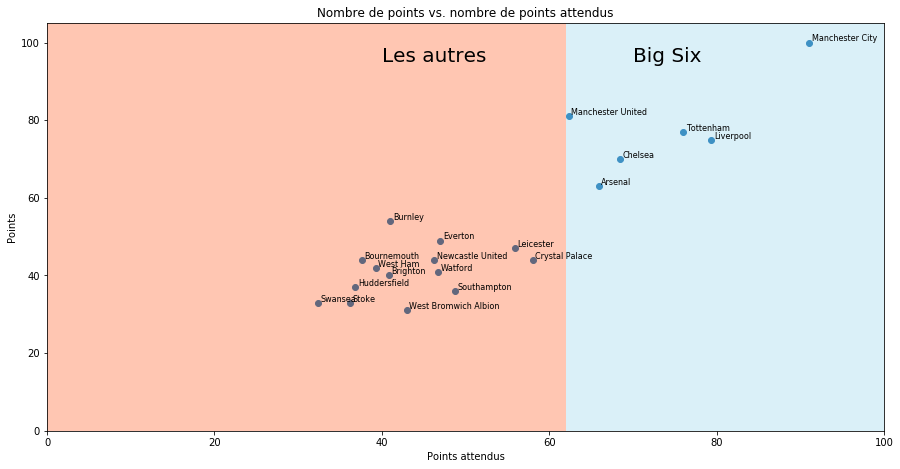

In [295]:
#graph 1

#on rentre les données que l'on souhaite dans chaque axe
x = classementEPL["xPTS"]
y = classementEPL["PTS"]
noms = classementEPL["Equipe"]

#style de l'annotation sur le graphique
style = dict(size = 8, color='black')

#initialisation du graphique
fig, plot1 = plt.subplots(figsize = (15, 7.5))
plot1.scatter(x, y) #création du nuage de points
plot1.set_xlim(0,100)
plot1.set_ylim(0,105)

#changement du background du graphique
plot1.axvspan(0, classementEPL["PTS"][5] - 1, facecolor = "orangered", alpha = 0.3)
plot1.axvspan(classementEPL["PTS"][5] - 1, classementEPL["PTS"][0], facecolor = "skyblue", alpha = 0.3)

plot1.set(title = "Nombre de points vs. nombre de points attendus", xlabel = "Points attendus", ylabel = "Points")

#annotations
plot1.text(70,95, "Big Six", {'color': 'black', 'fontsize': 20})
plot1.text(40,95, "Les autres", {'color': 'black', 'fontsize': 20})
for i, txt in enumerate(noms):
   plot1.annotate(txt, (x[i], y[i]), xytext = (x[i] + 0.3, y[i] + 0.3), **style)

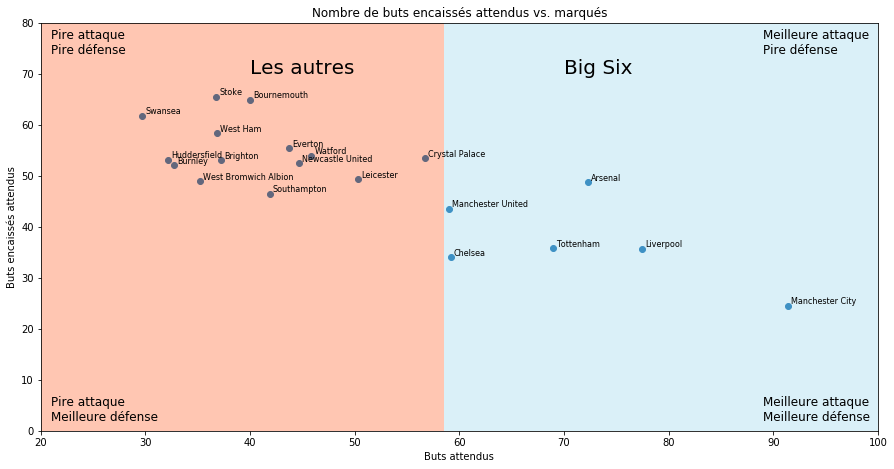

In [296]:
#graph 2

#on rentre les données que l'on souhaite dans chaque axe
x = classementEPL["xG"]
y = classementEPL["xGA"]
noms = classementEPL["Equipe"]

#style de l'annotation sur le graphique
style = dict(size = 8, color='black')

#initialisation du graphique
fig, plot2 = plt.subplots(figsize = (15, 7.5))
plot2.scatter(x, y) #création du nuage de points
plot2.set_xlim(20,100)
plot2.set_ylim(0,80)

#changement du background du graphique
plot2.axvspan(0, 58.5, facecolor = "orangered", alpha = 0.3)
plot2.axvspan(58.5, 100, facecolor = "skyblue", alpha = 0.3)

plot2.set(title = "Nombre de buts encaissés attendus vs. marqués", xlabel = "Buts attendus", ylabel = "Buts encaissés attendus")

#annotations
plot2.text(70,70, "Big Six", {'color': 'black', 'fontsize': 20})
plot2.text(40,70, "Les autres", {'color': 'black', 'fontsize': 20})
plot2.text(21,2, "Pire attaque \nMeilleure défense",{'color': 'black', 'fontsize': 12})
plot2.text(21,74, "Pire attaque \nPire défense",{'color': 'black', 'fontsize': 12})
plot2.text(89,74, "Meilleure attaque \nPire défense",{'color': 'black', 'fontsize': 12})
plot2.text(89,2, "Meilleure attaque \nMeilleure défense",{'color': 'black', 'fontsize': 12})

for i, txt in enumerate(noms):
   plot2.annotate(txt, (x[i], y[i]), xytext = (x[i] + 0.3, y[i] + 0.3), **style)

On voit bien avec ces graphiques que le top 6 se distingue de la masse et dans ce top 6 Manchester City est loin devant les autres du fait de leur saison exceptionnelle en termes statistiques.

Mais il se peut que Manchester City ait la meilleure défense en termes statistiques du fait d'une énorme possession de balle limitant l'exposition de sa défense aux attaques adverses. Ci-dessous les meilleurs défenses du championnat en termes de résistance à la pression sur situation d'attaque placée.

In [297]:
situationButs[situationButs["Situation"] == "Open play"].sort_values(by = "GA-xGA", ascending = True)

,Situation,Sh,G,ShA,GA,Diff,xG,xGA,xGD,G-xG,GA-xGA,xG/Sh,xGA/Sh,Equipe
0,Open play,405.0,52.0,333.0,15.0,37.0,46.639999,30.879999,15.760000,5.360001,-15.879999,0.12,0.09,Manchester United
0,Open play,245.0,28.0,418.0,29.0,-1.0,22.450001,39.900002,-17.450001,5.549999,-10.900002,0.09,0.10,Burnley
0,Open play,239.0,16.0,427.0,38.0,-22.0,21.160000,47.360001,-26.200001,-5.160000,-9.360001,0.09,0.11,Swansea
0,Open play,268.0,23.0,380.0,27.0,-4.0,23.010000,34.889999,-11.890000,-0.010000,-7.889999,0.09,0.09,Brighton
0,Open play,335.0,25.0,426.0,48.0,-23.0,27.040001,51.110001,-24.070000,-2.040001,-3.110001,0.08,0.12,Bournemouth
0,Open play,464.0,56.0,252.0,23.0,33.0,55.450001,25.559999,29.889999,0.549999,-2.559999,0.12,0.10,Tottenham
0,Open play,345.0,28.0,350.0,36.0,-8.0,33.490002,37.540001,-4.060000,-5.490002,-1.540001,0.10,0.11,Newcastle United
0,Open play,318.0,26.0,348.0,37.0,-11.0,34.599998,38.270000,-3.660000,-8.599998,-1.270000,0.11,0.11,Crystal Palace
0,Open play,273.0,24.0,406.0,50.0,-26.0,25.309999,49.439999,-24.129999,-1.309999,0.560001,0.09,0.12,Stoke
0,Open play,290.0,36.0,379.0,40.0,-4.0,33.049999,39.130001,-6.080000,2.950001,0.869999,0.11,0.10,Leicester


Manchester City est dans le dernier tiers du championnat, tout comme Liverpool ! On peut dès lors douter de la qualité intrinsèque de leurs défenseurs.

### 5.2. Styles de jeu, forces & faiblesses

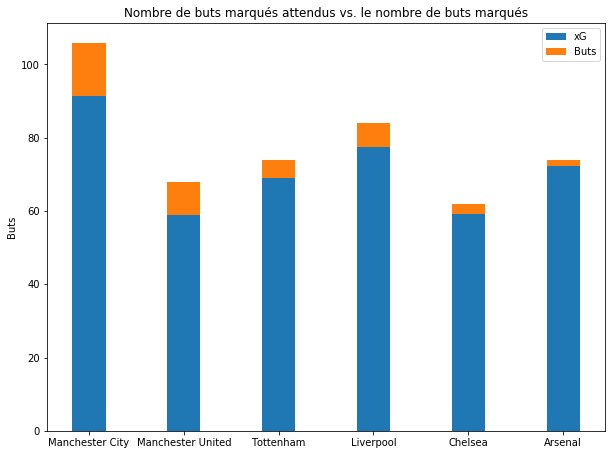

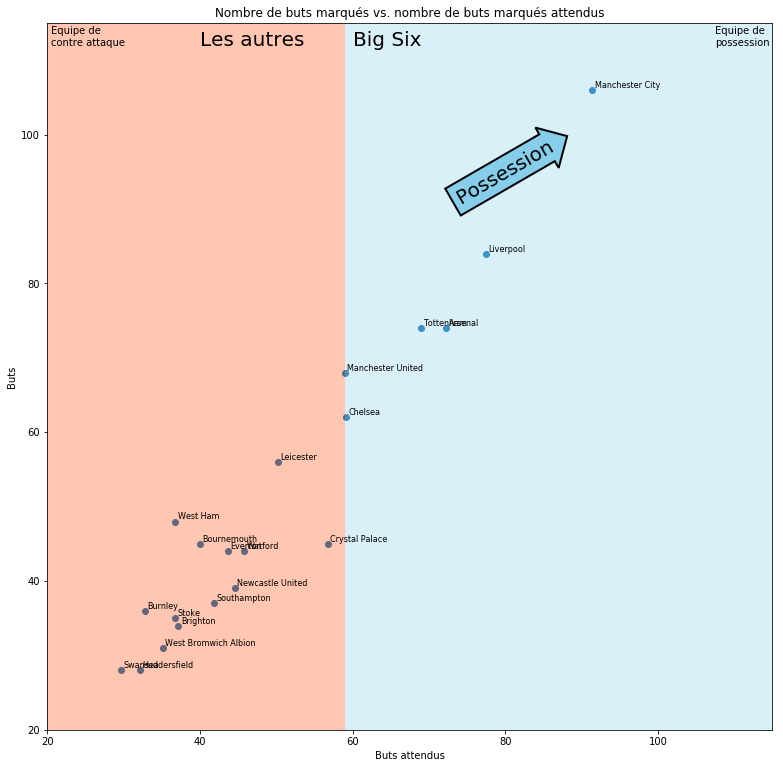

In [298]:
#graphique 3
#on rentre les données que l'on souhaite dans chaque axe
x = classementEPL["G"][:6] - classementEPL["xG"][:6]
y = classementEPL["xG"][:6]
noms = classementEPL["Equipe"][:6]

ind = np.arange(6) #on indique l'emplacement de chaque équipe sur l'axe x
width = 0.35 #la largeur des barres

plt.figure(figsize = (10, 7.5)) #la taille du graphique

plot3_1 = plt.bar(ind, y, width) #le premier bar plot
#le second bar plot superposé (puisque l'on a calculé la différence entre G et xG)
plot3_2 = plt.bar(ind, x, width, bottom = y) 

plt.ylabel("Buts") #nom de l'axe des y
plt.title("Nombre de buts marqués attendus vs. le nombre de buts marqués") #titre
plt.xticks(ind, noms) #nom de chaque barre
plt.legend((plot3_1[0], plot3_2[0]), ('xG', 'Buts')) #classification pour la légende


#graphique 4
#on rentre les données que l'on souhaite dans chaque axe
x2 = classementEPL["xG"]
y2 = classementEPL["G"]
noms = classementEPL["Equipe"]

#style de l'annotation sur le graphique
style = dict(size = 8, color='black')

#initialisation du graphique
fig, plot4 = plt.subplots(figsize = (13, 13))
plot4.scatter(x2, y2) #création du nuage de points
plot4.set_xlim(20,115)
plot4.set_ylim(20,115)

#changement du background du graphique
plot4.axvspan(0, 59, facecolor = "orangered", alpha = 0.3)
plot4.axvspan(59, 115, facecolor = "skyblue", alpha = 0.3)

plot4.set(title = "Nombre de buts marqués vs. nombre de buts marqués attendus", xlabel = "Buts attendus", ylabel = "Buts")

#annotations
plot4.text(60,112, "Big Six", {'color': 'black', 'fontsize': 20})
plot4.text(40,112, "Les autres", {'color': 'black', 'fontsize': 20})
plot4.text(20.5,112, "Equipe de \ncontre attaque", {'color': 'black', 'fontsize': 10})
plot4.text(107.5,112, "Equipe de \npossession", {'color': 'black', 'fontsize': 10})
bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="skyblue", ec="black", lw=2)
plot4.text(80, 95, "Possession", ha = "center", va = "center", rotation=30, size=20, bbox=bbox_props)

for i, txt in enumerate(noms):
   plot4.annotate(txt, (x2[i], y2[i]), xytext = (x2[i] + 0.3, y2[i] + 0.3), **style)

plt.show()

On peut voir les équipes du Big Six se distinguent des autres par leur style de jeu accès sur la possession de balle : on peut supposer qu'une équipe avec des xG élevés sur la saison et beaucoup de buts marqués est forte pour se créer des occasions, et donc détient le ballon la plupart du temps.

Parmi les équipes du Big Six on peut voir avec les 2 graphiques que Chelsea est l'équipe la moins orientée sur un jeu de possession de balle.

La forme du nuage de points nous indique également que la plupart des équipes sont plutôt bonnes pour convertir leurs occasions.

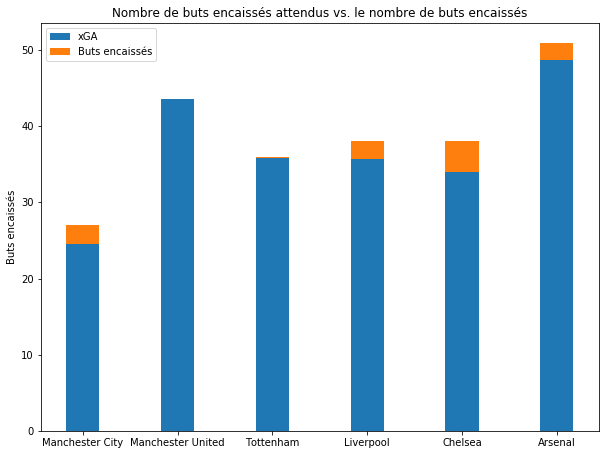

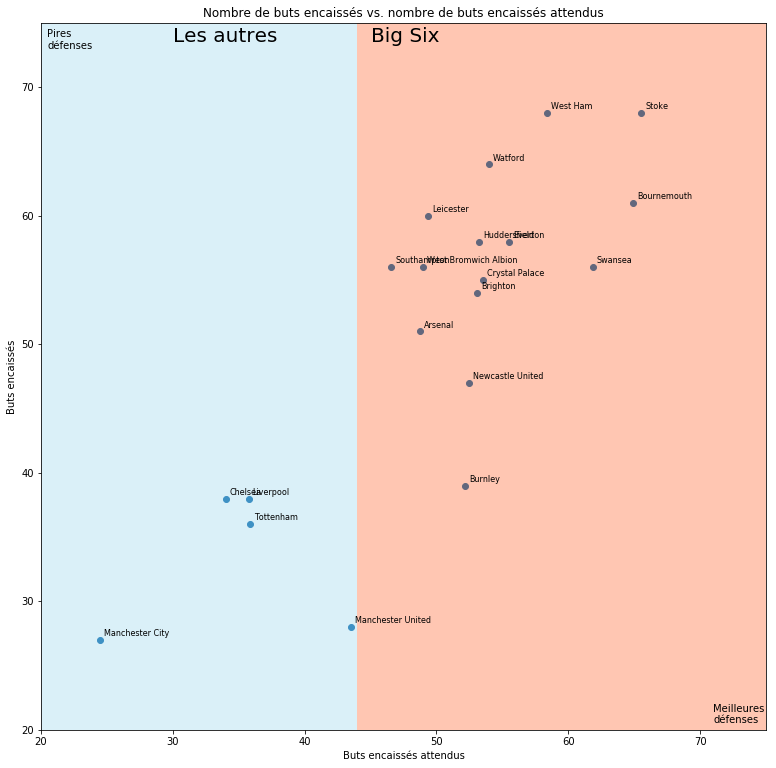

In [299]:
#graph 4 : bar chart diff Ga - xga top 6 + scatter plot ga vs xga tout le monde
#graphique 5
#on rentre les données que l'on souhaite dans chaque axe
x = classementEPL["GA"][:6] - classementEPL["xGA"][:6]
x[x < 0] = 0
y = classementEPL["xGA"][:6]
noms = classementEPL["Equipe"][:6]

ind = np.arange(6) #on indique l'emplacement de chaque équipe sur l'axe x
width = 0.35 #la largeur des barres

plt.figure(figsize = (10, 7.5)) #la taille du graphique

plot5_1 = plt.bar(ind, y, width) #le premier bar plot
#le second bar plot superposé (puisque l'on a calculé la différence entre G et xG)
plot5_2 = plt.bar(ind, x, width, bottom = y) 

plt.ylabel("Buts encaissés") #nom de l'axe des y
plt.title("Nombre de buts encaissés attendus vs. le nombre de buts encaissés") #titre
plt.xticks(ind, noms) #nom de chaque barre
plt.legend((plot5_1[0], plot5_2[0]), ('xGA', 'Buts encaissés')) #classification pour la légende


#graphique 6
#on rentre les données que l'on souhaite dans chaque axe
x2 = classementEPL["xGA"]
y2 = classementEPL["GA"]
noms = classementEPL["Equipe"]

#style de l'annotation sur le graphique
style = dict(size = 8, color='black')

#initialisation du graphique
fig, plot6 = plt.subplots(figsize = (13, 13))
plot6.scatter(x2, y2) #création du nuage de points
plot6.set_xlim(20,75)
plot6.set_ylim(20,75)

#changement du background du graphique
plot6.axvspan(0, 44, facecolor = "skyblue", alpha = 0.3)
plot6.axvspan(44, 80, facecolor = "orangered", alpha = 0.3)

plot6.set(title = "Nombre de buts encaissés vs. nombre de buts encaissés attendus", xlabel = "Buts encaissés attendus", ylabel = "Buts encaissés")

#annotations
plot6.text(45,73.5, "Big Six", {'color': 'black', 'fontsize': 20})
plot6.text(30,73.5, "Les autres", {'color': 'black', 'fontsize': 20})
plot6.text(20.5,73, "Pires \ndéfenses", {'color': 'black', 'fontsize': 10})
plot6.text(71,20.5, "Meilleures \ndéfenses", {'color': 'black', 'fontsize': 10})

for i, txt in enumerate(noms):
   plot6.annotate(txt, (x2[i], y2[i]), xytext = (x2[i] + 0.3, y2[i] + 0.3), **style)

plt.show()

On peut voir que Manchester United se distingue les autres équipes du Big Six de part la qualité de sa défense et/ou de son gardien, qui a concédé moins de buts que d'expected goals. Et qu'Arsenal se distingue de mauvaise manière pour la piètre qualité de sa défense, elle est sur ce point assez éloigné des autres équipes du Big Six.

## 6. Étude des performances individuelles offensives

### 6.1. Production offensive

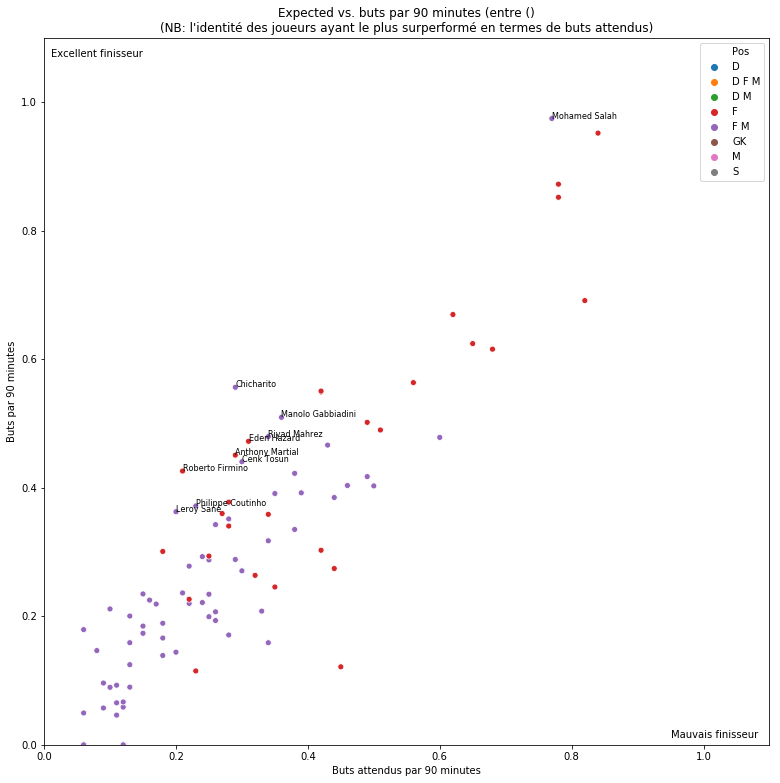

In [300]:
#graphique 7
#on rentre les données que l'on souhaite dans chaque axe
datas = {"xG90": statsIndividuelles[(statsIndividuelles["Min"] > 900) & (statsIndividuelles["Pos"].isin(["F", "F M"]))]["xG90"],
         "G90": statsIndividuelles[(statsIndividuelles["Min"] > 900) & (statsIndividuelles["Pos"].isin(["F", "F M"]))]["G90"],
         "Pos" : statsIndividuelles[(statsIndividuelles["Min"] > 900) & (statsIndividuelles["Pos"].isin(["F", "F M"]))]["Pos"]}

#on définit les coordonnées des joueurs pour lesquels on rajoutera le nom à côté de leur poit
noms = statsIndividuelles[(statsIndividuelles["Min"] > 900) & (statsIndividuelles["Pos"].isin(["F", "F M"]))].sort_values(by = "G90-xG90", ascending = False)["Player"].head(10).tolist()
xx = statsIndividuelles[statsIndividuelles["Player"].isin(noms)]["xG90"].tolist()
yy = statsIndividuelles[statsIndividuelles["Player"].isin(noms)]["G90"].tolist()

#initialisation du graphique
fig, plot7 = plt.subplots(figsize = (13, 13))
plot7 = sns.scatterplot(data = datas, x = "xG90", y = "G90", hue = "Pos")

#définition des axes
plot7.set_xlim(0,1.1)
plot7.set_ylim(0,1.1)
plot7.set_title("Expected vs. buts par 90 minutes (entre ()\n(NB: l'identité des joueurs ayant le plus surperformé en termes de buts attendus)")
plot7.set(xlabel = "Buts attendus par 90 minutes" , ylabel = "Buts par 90 minutes")
plot7.text(0.01,1.07, "Excellent finisseur", {'color': 'black', 'fontsize': 10})
plot7.text(0.95,0.01, "Mauvais finisseur", {'color': 'black', 'fontsize': 10})

#annotations
style = dict(size = 8, color='black')
for i, txt in enumerate(noms):
    plot7.text(x = xx[i], y = yy[i], s = noms[i], **style)

Ci-dessous les 10 joueurs au plus grand nombre de buts par 90 minutes.

In [301]:
statsIndividuelles[statsIndividuelles["Min"] > 900].sort_values(by = "G90", ascending = False).head(10)

,Player,Pos,Apps,Min,G,A,Sh90,G90,KP90,xG,xA,xG90,G-xG,G90-xG90,xG90/Sh90,xA90/KP90,xA90,A-xA,Equipe
0,Mohamed Salah,F M,36.0,2954.0,32.0,10.0,4.36,0.974949,1.89,25.139999,8.34,0.77,6.860001,0.204949,0.176605,0.132275,0.25,1.66,Liverpool
0,Sergio Agüero,F,25.0,1985.0,21.0,6.0,4.31,0.952141,1.77,18.570000,6.53,0.84,2.430000,0.112141,0.194896,0.169492,0.30,-0.53,Manchester City
0,Harry Kane,F,37.0,3094.0,30.0,2.0,5.32,0.872657,0.99,26.860001,3.82,0.78,3.139999,0.092657,0.146617,0.111111,0.11,-1.82,Tottenham
1,Pierre-Emerick Aubameyang,F,13.0,1056.0,10.0,4.0,2.64,0.852273,1.11,9.170000,1.26,0.78,0.830000,0.072273,0.295455,0.099099,0.11,2.74,Arsenal
2,Gabriel Jesus,F,29.0,1692.0,13.0,3.0,2.93,0.691489,0.96,15.370000,2.31,0.82,-2.370000,-0.128511,0.279863,0.125000,0.12,0.69,Manchester City
1,Oumar Niasse,F,22.0,1075.0,8.0,2.0,3.10,0.669767,0.92,7.420000,1.55,0.62,0.580000,0.049767,0.200000,0.141304,0.13,0.45,Everton
1,Raheem Sterling,F,33.0,2594.0,18.0,11.0,3.02,0.624518,1.91,18.830000,8.84,0.65,-0.830000,-0.025482,0.215232,0.162304,0.31,2.16,Manchester City
0,Charlie Austin,F,24.0,1023.0,7.0,0.0,4.13,0.615836,0.35,7.720000,0.69,0.68,-0.720000,-0.064164,0.164649,0.171429,0.06,-0.69,Southampton
0,Alexandre Lacazette,F,32.0,2235.0,14.0,4.0,2.70,0.563758,1.45,13.830000,4.84,0.56,0.170000,0.003758,0.207407,0.131034,0.19,-0.84,Arsenal
3,Philippe Coutinho,F M,14.0,1132.0,7.0,6.0,4.29,0.556537,3.18,3.640000,4.95,0.29,3.360000,0.266537,0.067599,0.122642,0.39,1.05,Liverpool


Et les 10 joueurs au plus grand nombre de buts attendus par 90 minutes.

In [302]:
statsIndividuelles[statsIndividuelles["Min"] > 900].sort_values(by = "xG90", ascending = False).head(10)

,Player,Pos,Apps,Min,G,A,Sh90,G90,KP90,xG,xA,xG90,G-xG,G90-xG90,xG90/Sh90,xA90/KP90,xA90,A-xA,Equipe
0,Sergio Agüero,F,25.0,1985.0,21.0,6.0,4.31,0.952141,1.77,18.570000,6.53,0.84,2.430000,0.112141,0.194896,0.169492,0.30,-0.53,Manchester City
2,Gabriel Jesus,F,29.0,1692.0,13.0,3.0,2.93,0.691489,0.96,15.370000,2.31,0.82,-2.370000,-0.128511,0.279863,0.125000,0.12,0.69,Manchester City
0,Harry Kane,F,37.0,3094.0,30.0,2.0,5.32,0.872657,0.99,26.860001,3.82,0.78,3.139999,0.092657,0.146617,0.111111,0.11,-1.82,Tottenham
1,Pierre-Emerick Aubameyang,F,13.0,1056.0,10.0,4.0,2.64,0.852273,1.11,9.170000,1.26,0.78,0.830000,0.072273,0.295455,0.099099,0.11,2.74,Arsenal
0,Mohamed Salah,F M,36.0,2954.0,32.0,10.0,4.36,0.974949,1.89,25.139999,8.34,0.77,6.860001,0.204949,0.176605,0.132275,0.25,1.66,Liverpool
0,Charlie Austin,F,24.0,1023.0,7.0,0.0,4.13,0.615836,0.35,7.720000,0.69,0.68,-0.720000,-0.064164,0.164649,0.171429,0.06,-0.69,Southampton
1,Raheem Sterling,F,33.0,2594.0,18.0,11.0,3.02,0.624518,1.91,18.830000,8.84,0.65,-0.830000,-0.025482,0.215232,0.162304,0.31,2.16,Manchester City
1,Oumar Niasse,F,22.0,1075.0,8.0,2.0,3.10,0.669767,0.92,7.420000,1.55,0.62,0.580000,0.049767,0.200000,0.141304,0.13,0.45,Everton
1,Álvaro Morata,F M,31.0,2069.0,11.0,6.0,3.44,0.478492,1.57,13.900000,3.58,0.60,-2.900000,-0.121508,0.174419,0.101911,0.16,2.42,Chelsea
0,Alexandre Lacazette,F,32.0,2235.0,14.0,4.0,2.70,0.563758,1.45,13.830000,4.84,0.56,0.170000,0.003758,0.207407,0.131034,0.19,-0.84,Arsenal


On peut voir sur la base des données ci-dessus que Mohamed Salah a été l'attaquant le plus efficace de Premier League par sa capacité à se créer des occasions et les convertir en buts.

Les performances de Sergio Aguero sont également à noter car il est le joueur ayant le plus grand nombre de buts attendus par 90 minutes sur la saison. Il est certes bien entouré avec de nombreux passeurs de qualité, mais il est très productif avec un temps de jeu inférieur par rapport à ses concurrents.

### 6.2. Intelligence offensive

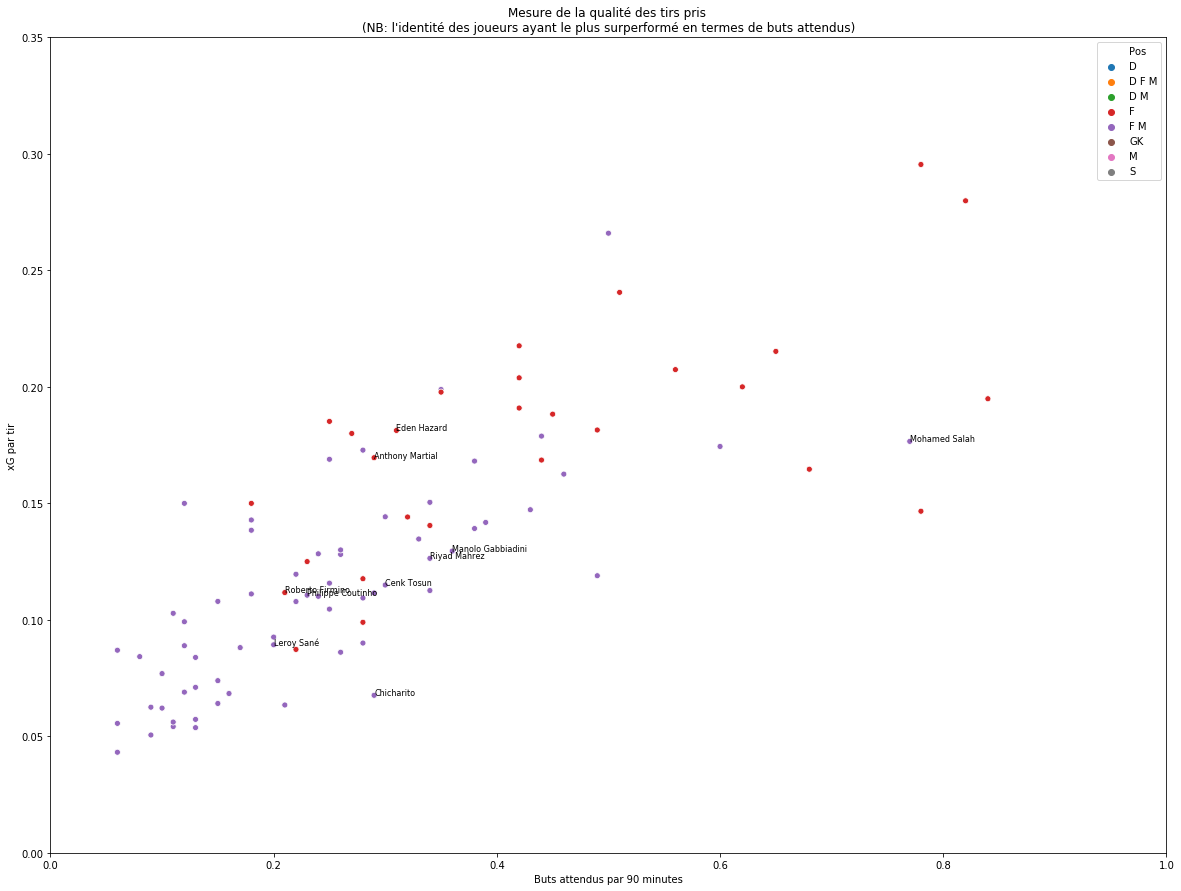

In [303]:
#graphique 8
#on rentre les données que l'on souhaite dans chaque axe
datas = {"xG90": statsIndividuelles[(statsIndividuelles["Min"] > 900) & (statsIndividuelles["Pos"].isin(["F", "F M"]))]["xG90"],
         "xG90/Sh90": statsIndividuelles[(statsIndividuelles["Min"] > 900) & (statsIndividuelles["Pos"].isin(["F", "F M"]))]["xG90/Sh90"],
         "Pos" : statsIndividuelles[(statsIndividuelles["Min"] > 900) & (statsIndividuelles["Pos"].isin(["F", "F M"]))]["Pos"]}

#on définit les coordonnées des joueurs pour lesquels on rajoutera le nom à côté de leur poit
noms = statsIndividuelles[(statsIndividuelles["Min"] > 900) & (statsIndividuelles["Pos"].isin(["F", "F M"]))].sort_values(by = "G90-xG90", ascending = False)["Player"].head(10).tolist()
xx = statsIndividuelles[statsIndividuelles["Player"].isin(noms)]["xG90"].tolist()
yy = statsIndividuelles[statsIndividuelles["Player"].isin(noms)]["xG90/Sh90"].tolist()

#initialisation du graphique
fig, plot8 = plt.subplots(figsize = (20, 15))
plot8 = sns.scatterplot(data = datas, x = "xG90", y = "xG90/Sh90", hue = "Pos")

#définition des axes
plot8.set_xlim(0,1)
plot8.set_ylim(0,0.35)
plot8.set_title("Mesure de la qualité des tirs pris \n(NB: l'identité des joueurs ayant le plus surperformé en termes de buts attendus)")
plot8.set(xlabel = "Buts attendus par 90 minutes" , ylabel = "xG par tir")

#annotations
style = dict(size = 8, color='black')
for i, txt in enumerate(noms):
    plot8.text(x = xx[i], y = yy[i], s = noms[i], **style)

Ci-dessous les 10 joueurs ayant la meilleure sélection de tirs pris.

In [304]:
statsIndividuelles[(statsIndividuelles["Min"] > 900) & (statsIndividuelles["Pos"].isin(["F", "F M"]))].sort_values(by = "xG90/Sh90", ascending = False).head(10)

,Player,Pos,Apps,Min,G,A,Sh90,G90,KP90,xG,xA,xG90,G-xG,G90-xG90,xG90/Sh90,xA90/KP90,xA90,A-xA,Equipe
1,Pierre-Emerick Aubameyang,F,13.0,1056.0,10.0,4.0,2.64,0.852273,1.11,9.17,1.26,0.78,0.83,0.072273,0.295455,0.099099,0.11,2.74,Arsenal
2,Gabriel Jesus,F,29.0,1692.0,13.0,3.0,2.93,0.691489,0.96,15.37,2.31,0.82,-2.37,-0.128511,0.279863,0.125000,0.12,0.69,Manchester City
2,Shinji Okazaki,F M,27.0,1340.0,6.0,2.0,1.88,0.402985,1.01,7.49,1.85,0.50,-1.49,-0.097015,0.265957,0.118812,0.12,0.15,Leicester
0,Glenn Murray,F,35.0,2204.0,12.0,0.0,2.12,0.490018,0.65,12.38,1.24,0.51,-0.38,-0.019982,0.240566,0.076923,0.05,-1.24,Brighton
0,Jamie Vardy,F,37.0,3269.0,20.0,1.0,1.93,0.550627,0.91,15.27,3.63,0.42,4.73,0.130627,0.217617,0.109890,0.10,-2.63,Leicester
1,Raheem Sterling,F,33.0,2594.0,18.0,11.0,3.02,0.624518,1.91,18.83,8.84,0.65,-0.83,-0.025482,0.215232,0.162304,0.31,2.16,Manchester City
0,Alexandre Lacazette,F,32.0,2235.0,14.0,4.0,2.70,0.563758,1.45,13.83,4.84,0.56,0.17,0.003758,0.207407,0.131034,0.19,-0.84,Arsenal
2,Andre Gray,F,31.0,1486.0,5.0,2.0,2.06,0.302826,1.03,7.00,2.32,0.42,-2.00,-0.117174,0.203883,0.135922,0.14,-0.32,Watford
1,Oumar Niasse,F,22.0,1075.0,8.0,2.0,3.10,0.669767,0.92,7.42,1.55,0.62,0.58,0.049767,0.200000,0.141304,0.13,0.45,Everton
0,Wayne Rooney,F M,31.0,2301.0,10.0,2.0,1.76,0.391134,1.33,8.91,2.28,0.35,1.09,0.041134,0.198864,0.067669,0.09,-0.28,Everton


On peut voir que les joueurs ayant le plus performé en termes de buts attendus ne sont pas ceux qui ont la meilleure sélection de tirs.

# End